# Gene tracks

Plots of all the gene tracks for the NLR/RPP7 paper

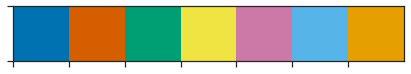

In [1]:
import sys
import os
import re
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches, gridspec
import seaborn as sns

import pysam
import pyBigWig as pybw

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
def bam_cigar_to_invs(aln):
    invs = []
    start = aln.reference_start
    end = aln.reference_end
    strand = '-' if aln.is_reverse else '+'
    left = start
    right = left
    has_ins = False
    for op, ln in aln.cigar:
        if op in (1, 4, 5):
            # does not consume reference
            continue
        elif op in (0, 2, 7, 8):
            # consume reference but do not add to invs yet
            right += ln
        elif op == 3:
            invs.append([left, right])
            left = right + ln
            right = left
    if right > left:
        invs.append([left, right])
    assert invs[0][0] == start
    assert invs[-1][1] == end
    return start, end, strand, np.array(invs)


def bam_query_iterator(bam, *args, **kwargs):
    strand = kwargs.pop('strand', None)
    if strand is None or strand == '.':
        for aln in bam.fetch(*args, **kwargs):
            yield bam_cigar_to_invs(aln)
    elif strand in '+-':
        is_reverse = strand == '-'
        for aln in bam.fetch(*args, **kwargs):
            if is_reverse == aln.is_reverse:
                yield bam_cigar_to_invs(aln)
    else:
        raise ValueError('strand is not one of +-.')


def random_undersample_bam_query(bam, chrom, start, end, strand=None,
                                 sample_size=100, random_state=None):
    invs = []
    for s, e, _, i in bam_query_iterator(bam, chrom, start, end, strand=strand):
        if strand == '+' or strand is None:
            invs.append(i - start)
        else:
            i = np.rot90(end - i, 2)
            invs.append(i)
    if len(invs) <= sample_size:
        return invs
    else:
        idx = np.arange(len(invs))
        if random_state is None:
            idx = np.random.choice(idx, size=sample_size, replace=False)
        else:
            if isinstance(random_state, int):
                random_state = np.random.RandomState(random_state)
            idx = random_state.choice(idx, size=sample_size, replace=False)
        invs = [invs[i] for i in idx]
        return invs

In [3]:
def trim_invs(invs, max_length):
    trimmed = []
    for i in invs:
        t = []
        for s, e in i:
            if e <= 0:
                continue
            elif s < 0:
                t.append([0, e])
            elif s >= max_length:
                continue
            elif e > max_length:
                t.append([s, max_length])
            elif (0 <= s < max_length) and (0 < e <= max_length):
                t.append([s, e])
        if t:
            trimmed.append(np.array(t))
    return trimmed

def plot_inv(i, ax, color, intron_color, y, h):
    if len(i) > 1:
        s, e = i[0, 1], i[-1, 0]
        ax.plot([s, e], [y + h / 2, y + h / 2], color=intron_color, zorder=0)
    for start, end in i:
        p = patches.Rectangle((start, y), width=end-start, height=h, color=color, zorder=1)
        ax.add_patch(p)

def plot_invs(invs, ax, color, y_offset=0, h=1):
    y = y_offset
    for i in invs:
        plot_inv(i, ax, color, '#eeeeee', y, h)
        y = y + h + h / 10
    return ax

In [4]:
def plot_nanopore(bam_fns, labels, colours,
                  chrom, start, end, strand,
                  sample_size=100, random_seed=101,
                  ax=None, height=1, xpad=500, ypad=10,
                  label_side='right', font_size=10):
    random_state = np.random.RandomState(random_seed)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    y_offset = 0
    xlim = (0, end - start)
    for bam_fn, label, colour in zip(bam_fns, labels, colours):
        y_offset += ypad * height
        with pysam.AlignmentFile(bam_fn) as bam:
            invs = random_undersample_bam_query(
                bam, chrom, start, end, strand,
                sample_size, random_state
            )
        invs = sorted(invs, key=lambda k: k[-1][1], reverse=True)
        invs = trim_invs(invs, end - start)
        plot_invs(invs, ax, colour, y_offset)
        y_offset += len(invs) * height
        if label_side == 'right':
            ax.annotate(label, xy=(xlim[1], y_offset),
                        ha='right', va='top', fontsize=font_size)
        else:
            ax.annotate(label, xy=(xlim[0], y_offset),
                        ha='left', va='top', fontsize=font_size)
    ax.set_xlim(*xlim)
    ax.set_ylim(y_offset + ypad, 0)
    return ax

In [5]:
def get_binned(bw, chrom, start, end, strand, binsize, y_norm='CPM'):
    vals = bw.values(chrom, start, end, numpy=True)
    if strand == '-':
        vals = vals[::-1]
    vals[np.isnan(vals)] = 0
    if binsize != 1:
        assert binsize > 0
        vals = np.array([sum(vals[i: i + binsize]) for i in np.arange(0, len(vals), binsize)])
    if y_norm == 'Coverage (density)':
        vals /= vals.sum()
    return vals

def plot_helicos(bw_fn, colour,
                 chrom, start, end, strand,
                 ax=None, binsize=10,
                 label=None, font_size=10,
                 y_norm='CPM'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    bw = pybw.open(bw_fn)
    vals = get_binned(bw, chrom, start, end, strand, binsize, y_norm)
    ax.bar(
        np.arange(0, end - start, binsize),
        vals,
        width=binsize,
        color=colour,
    )
    if label is not None:
        ax.annotate(
            s=label,
            xy=(0.01, 0.95),
            ha='left',
            va='top',
            xycoords='axes fraction',
            fontsize=font_size
        )
    return ax

In [6]:
def plot_illumina(bw_fns, labels, colours,
                  chrom, start, end, strand, 
                  ax=None, font_size=10, y_norm='CPM'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    for bw_fn, label, colour in zip(bw_fns, labels, colours):
        bw = pybw.open(bw_fn)
        vals = get_binned(bw, chrom, start, end, strand, 1, y_norm)
        ax.plot(
            vals,
            color=colour,
            label=label
        )
    ax.legend(loc=0, title='Illumina RNAseq',
              fontsize=font_size, title_fontsize=font_size)
    ax.ticklabel_format(scilimits=(0, 0))
    return ax

In [7]:
def get_xticklabels(ax, start_coord, end_coord, strand):
    xticks = ax.get_xticks()
    if strand == '+':
        xticks = xticks + start_coord
    else:
        xticks = np.abs(end_coord - xticks)
    xticklabels = []
    for x in xticks:
        if x > 1_000:
            x = f'{x / 1_000:.1f}kb'
        else:
            x = f'{x:d}'
        xticklabels.append(x)
    return xticklabels

In [8]:
def parse_exons(record):
    start = int(record[1])
    end = int(record[2])
    exstarts = np.fromstring(record[11], sep=',') + start
    exends = exstarts + np.fromstring(record[10], sep=',')
    exons = np.dstack([exstarts, exends])[0]
    return exons


def get_annotation(annot_fn, chrom, start, end, strand, whitelist=None):
    invs = []
    with pysam.TabixFile(annot_fn) as f:
        for record in f.fetch(chrom, start, end):
            record = record.split()
            exons = parse_exons(record)
            if strand == '+':
                exons -= start
            else:
                exons = np.rot90(np.abs(exons - end), 2)
            gene_id = record[3]
            if whitelist is None or gene_id in whitelist:
                invs.append([gene_id, exons])
    return invs


def get_chromstate(chromstate_fn, chrom, start, end, strand):
    invs = []
    colours = []
    with pysam.TabixFile(chromstate_fn) as f:
        for record in f.fetch(chrom, start, end):
            record = record.split()
            _, s, e, *_, colour = record[:-3]
            s = int(s)
            e = int(e)
            colour = np.fromstring(colour, sep=',') / 255
            invs.append([[s, e]])
            colours.append(colour)
    invs = np.array(invs)
    if strand == '+':
        invs -= start
    else:
        invs = np.rot90(np.abs(invs - end), 2)
        colours = colours[::-1]
    return invs, colours


def plot_annot(annot_fn, chromstate_fn,
               chrom, start, end, strand,
               whitelist, extra_annot=None,
               add_chromatin_state=True,
               ax=None, font_size=10):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    if add_chromatin_state:
        state = get_chromstate(chromstate_fn, chrom, start, end, strand)
        for inv, colour in zip(*state):
            try:
                inv, = trim_invs([inv], end - start)
            except ValueError:
                continue
            plot_inv(inv, ax, colour, colour, 0, 1)
    invs = get_annotation(annot_fn, chrom, start, end, strand, whitelist)
    if extra_annot is not None:
        invs = invs + extra_annot
    for y, (gene_id, inv) in enumerate(invs, 1):
        try:
            inv, = trim_invs([inv], end - start)
        except ValueError:
            continue
        plot_inv(inv, ax, '#252525', '#252525', y * 2, 1)
        ax.annotate(gene_id,
                    xy=((inv[0,0] + inv[-1,-1]) / 2, y * 2 - 0.2),
                    va='top', ha='center',
                    fontsize=font_size)
    ax.set_ylim(-1, y * 2 + 2)
    return ax


def plot_interpro(interpro_fn,
                  chrom, start, end, strand,
                  ax=None, font_size=10, color='#252525'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    invs = get_annotation(interpro_fn, chrom, start, end, strand)
    for y, (label, inv) in enumerate(invs, 1):
        try:
            inv, = trim_invs([inv], end - start)
        except ValueError:
            continue
        plot_inv(inv, ax, color, color, y * 2, 1)
        ax.annotate(label,
                    xy=((inv[0,0] + inv[-1,-1]) / 2, y * 2 - 0.2),
                    va='top', ha='center',
                    fontsize=font_size)
    ax.set_ylim(-1, y * 2 + 2)
    return ax

In [9]:
def plot_nanopore_helicos_illumina(query, annot_whitelist,
                                   figsize=(10, 15),
                                   nanopore_rows=5,
                                   illumina_rows=2,
                                   helicos_rows=1,
                                   annot_rows=1,
                                   extra_annot=None,
                                   interpro_rows=1,
                                   title=None,
                                   helicos_binsize=100,
                                   nanopore_sample_size=200,
                                   illumina_y='Coverage (density)',
                                   add_chromatin_state=True,
                                   add_interpro=False,
                                   add_nanoPARE=False):

    assert illumina_y in ['CPM', 'Coverage (density)']

    s = 'fwd' if query[3] == '+' else 'rev'

    fig = plt.figure(figsize=figsize)
    interpro_rows = 0 if not add_interpro else interpro_rows
    nanoPARE_rows = 0 if not add_nanoPARE else helicos_rows
    grid = (nanopore_rows + nanoPARE_rows + 3 * helicos_rows + illumina_rows + annot_rows + interpro_rows, 1)

    illumina_ax = plt.subplot2grid(grid, loc=(0, 0), rowspan=illumina_rows)

    plot_illumina(
        [
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/col0.cpm.{s}.bw',
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/fpa8.cpm.{s}.bw',
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/35SFPA.cpm.{s}.bw',
        ],
        [
            'Col-0', 'fpa-8', '35S::FPA'
        ],
        pal[:3],
        *query,
        ax=illumina_ax,
        y_norm=illumina_y,
    )

    plt.setp(illumina_ax.get_xticklabels(), visible=False)
    illumina_ax.set_ylabel(illumina_y)
    sns.despine(ax=illumina_ax)

    if add_nanoPARE:
        nanoPARE_ax = plt.subplot2grid(grid, (illumina_rows, 0), sharex=illumina_ax)
        plot_helicos(
            f'../../../nanoPARE/coverage_tracks/5P/pooled.capped.5{s}_genomecov.bw',
            pal[4],  *query, binsize=helicos_binsize, label='nanoPARE', ax=nanoPARE_ax,
            y_norm=illumina_y,
        )
        plt.setp(nanoPARE_ax.get_xticklabels(), visible=False)
        sns.despine(ax=nanoPARE_ax, top=True, right=True)
        illumina_rows += nanoPARE_rows

    helicos_ax = None

    helicos_grid = [
        illumina_rows + helicos_rows * i for i in range(3)
    ]

    helicos_axes = []
    for sn, label, colour, i in zip(['col0', 'fpa8', '35SFPA'],
                                    ['Col-0 Helicos DRS',
                                     'fpa-8 Helicos DRS',
                                     '35S::FPA Helicos DRS'],
                                    pal[:3], helicos_grid):
        helicos_ax = plt.subplot2grid(grid, (i, 0), sharex=illumina_ax, sharey=helicos_ax)
        plot_helicos(
            f'../helicos_apa_pipeline/pipeline/coverage_tracks/{sn}.cpm.{s}.bw',
            colour,  *query, binsize=helicos_binsize, label=label, ax=helicos_ax,
            y_norm=illumina_y,
        )
        plt.setp(helicos_ax.get_xticklabels(), visible=False)
        #helicos_ax.set_ylabel(illumina_y)
        sns.despine(ax=helicos_ax, top=True, right=True)
        helicos_axes.append(helicos_ax)

    nanopore_row_start = i + helicos_rows
    nanopore_ax = plt.subplot2grid(grid,
                                   (nanopore_row_start, 0),
                                   rowspan=nanopore_rows,
                                   sharex=illumina_ax)

    plot_nanopore(
        ['../nanopore_apa_pipeline/pipeline/aligned_data/pooled/col0.bam',
         '../nanopore_apa_pipeline/pipeline/aligned_data/pooled/fpa8.bam',
         '../nanopore_apa_pipeline/pipeline/aligned_data/pooled/35SFPA.bam'],
        ['Col-0 Nanopore DRS', 'fpa-8 Nanopore DRS', '35S::FPA Nanopore DRS'],
        pal[:3],
        *query,
        sample_size=nanopore_sample_size,
        ax=nanopore_ax,
        ypad=20
    )
    sns.despine(ax=nanopore_ax, top=True, right=True, left=True, bottom=True)
    nanopore_ax.set_yticks([])
    plt.setp(nanopore_ax.get_xticklabels(), visible=False)

    annot_row_start = nanopore_row_start + nanopore_rows
    annot_ax = plt.subplot2grid(grid,
                                (annot_row_start, 0),
                                rowspan=annot_rows,
                                sharex=illumina_ax)

    plot_annot(
        '../illumina_rnaseq_pipeline/annotations/Araport11_prot_coding_and_non_coding.bed.gz',
        '../illumina_rnaseq_pipeline/annotations/at_chromhmm_states_coloured.bed.gz',
        *query, annot_whitelist, ax=annot_ax, extra_annot=extra_annot,
        add_chromatin_state=add_chromatin_state
    )
    sns.despine(ax=annot_ax, top=True, right=True, left=True)
    annot_ax.set_yticks([])

    if add_interpro:
        interpro_row_start = annot_row_start + annot_rows
        interpro_ax = plt.subplot2grid(grid,
                                       (interpro_row_start, 0),
                                       rowspan=interpro_rows,
                                       sharex=illumina_ax)
        plot_interpro(
            '../nanopore_apa_pipeline/annotations/araport_interpro_mapping.bed.gz',
            *query, ax=interpro_ax
        )
        plt.setp(annot_ax.get_xticklabels(), visible=False)
        sns.despine(ax=interpro_ax, top=True, right=True, left=True)
        interpro_ax.set_yticks([])
        interpro_ax.set_xticklabels(get_xticklabels(interpro_ax, query[1], query[2], query[3]))
        interpro_ax.set_xlabel(f'Chr{query[0]}')
        
    else:
        annot_ax.set_xticklabels(get_xticklabels(annot_ax, query[1], query[2], query[3]))
        annot_ax.set_xlabel(f'Chr{query[0]}')

    if title is not None:
        illumina_ax.set_title(title)
    plt.tight_layout()
    return fig, illumina_ax, helicos_axes, nanopore_ax, annot_ax

In [10]:
def plot_fpa_polii_chipseq(query, annot_whitelist,
                           figsize=(10, 12),
                           illumina_rows=2,
                           helicos_rows=1,
                           annot_rows=1,
                           helicos_binsize=50,
                           title=None):

    s = 'fwd' if query[3] == '+' else 'rev'

    fig = plt.figure(figsize=figsize)
    grid = (3 * illumina_rows + 2 * helicos_rows + annot_rows, 1)

    fpa_ax = plt.subplot2grid(grid, loc=(0, 0), rowspan=illumina_rows)

    plot_illumina(
        [
            f'../chipseq_pipeline/pipeline/fpa/coverage_tracks/input.bw',
            f'../chipseq_pipeline/pipeline/fpa/coverage_tracks/FPA.bw',
        ],
        [
            'Input', 'FPA'
        ],
        pal[:2],
        *query,
        ax=fpa_ax
    )

    plt.setp(fpa_ax.get_xticklabels(), visible=False)
    fpa_ax.set_ylabel('CPM')
    sns.despine(ax=fpa_ax)

    for i,  ab in enumerate(['s5p', 's2p'], 1):
        polii_ax = plt.subplot2grid(grid,
                                    loc=(illumina_rows * i, 0),
                                    rowspan=illumina_rows,
                                    sharex=fpa_ax)

        plot_illumina(
            [
                f'../chipseq_pipeline/pipeline/polii/coverage_tracks/{ab}_wt.bw',
                f'../chipseq_pipeline/pipeline/polii/coverage_tracks/{ab}_fpa7.bw',
            ],
            [
                'Col-0', 'fpa-7'
            ],
            pal[:2],
            *query,
            ax=polii_ax
        )

        plt.setp(polii_ax.get_xticklabels(), visible=False)
        polii_ax.set_ylabel('CPM')
        sns.despine(ax=polii_ax)


    helicos_ax = None

    helicos_grid = [
        illumina_rows * 3 + helicos_rows * i for i in range(2)
    ]

    helicos_axes = []
    for sn, label, colour, i in zip(['col0', 'fpa8'],
                                    ['Col-0 Helicos DRS',
                                     'fpa-8 Helicos DRS'],
                                    pal[:2], helicos_grid):
        helicos_ax = plt.subplot2grid(grid, (i, 0), sharex=fpa_ax, sharey=helicos_ax)
        plot_helicos(
            f'../helicos_apa_pipeline/pipeline/coverage_tracks/{sn}.cpm.{s}.bw',
            colour,  *query, binsize=helicos_binsize, label=label, ax=helicos_ax,
        )
        plt.setp(helicos_ax.get_xticklabels(), visible=False)
        helicos_ax.set_ylabel('CPM')
        sns.despine(ax=helicos_ax, top=True, right=True)
        helicos_axes.append(helicos_ax)

    annot_ax = plt.subplot2grid(grid,
                                (3 * illumina_rows + 2 * helicos_rows, 0),
                                rowspan=annot_rows,
                                sharex=fpa_ax)

    plot_annot(
        '../illumina_rnaseq_pipeline/annotations/Araport11_prot_coding_and_non_coding.bed.gz',
        '../illumina_rnaseq_pipeline/annotations/at_chromhmm_states_coloured.bed.gz',
        *query, annot_whitelist, ax=annot_ax,
        add_chromatin_state=False
    )

    sns.despine(ax=annot_ax, top=True, right=True, left=True)
    annot_ax.set_yticks([])
    annot_ax.set_xticklabels(get_xticklabels(annot_ax, query[1], query[2], query[3]))
    annot_ax.set_xlabel(f'Chr{query[0]}')

    if title is not None:
        fpa_ax.set_title(title)
    plt.tight_layout()
    return fig

In [11]:
def plot_decay_factor_illumina(query, annot_whitelist,
                               figsize=(10, 12),
                               illumina_rows=2,
                               annot_rows=1,
                               title=None,
                               illumina_y='CPM'):

    assert illumina_y in ['CPM', 'Coverage (density)']
    
    s = 'fwd' if query[3] == '+' else 'rev'

    fig = plt.figure(figsize=figsize)
    grid = (4 * illumina_rows + annot_rows, 1)

    chx_ax = plt.subplot2grid(grid, loc=(0, 0), rowspan=illumina_rows, sharex=None)

    plot_illumina(
        [
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/pooled/col0mock.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/pooled/col0chx.bw',
        ],
        [
            'Mock', 'CHX',
        ],
        pal[:2],
        *query,
        ax=chx_ax,
        y_norm=illumina_y
    )

    plt.setp(chx_ax.get_xticklabels(), visible=False)
    chx_ax.set_ylabel(illumina_y)
    sns.despine(ax=chx_ax)

    upf_ax = plt.subplot2grid(grid, loc=(illumina_rows, 0), rowspan=illumina_rows, sharex=chx_ax, sharey=chx_ax)

    plot_illumina(
        [
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/pooled/col0.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/pooled/upf1.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/upf1upf3_rnaseq/coverage_tracks/pooled/upf3.bw',
        ],
        [
            'Col-0', 'upf1', 'upf3',
        ],
        pal[:4],
        *query,
        ax=upf_ax,
        y_norm=illumina_y
    )

    plt.setp(upf_ax.get_xticklabels(), visible=False)
    upf_ax.set_ylabel(illumina_y)
    sns.despine(ax=upf_ax)

    pel_ax = plt.subplot2grid(grid, loc=(2 * illumina_rows, 0), rowspan=illumina_rows, sharex=chx_ax, sharey=chx_ax)

    plot_illumina(
        [
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/pelota_rnaseq/coverage_tracks/pooled/col0.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/pelota_rnaseq/coverage_tracks/pooled/hbs1.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/pelota_rnaseq/coverage_tracks/pooled/pel1.bw',
        ],
        [
            'Col-0', 'hbs-1', 'pel-1',
        ],
        pal[:3],
        *query,
        ax=pel_ax,
        y_norm=illumina_y
    )

    plt.setp(pel_ax.get_xticklabels(), visible=False)
    pel_ax.set_ylabel(illumina_y)
    sns.despine(ax=pel_ax)

    ski_ax = plt.subplot2grid(grid, loc=(3 * illumina_rows, 0), rowspan=illumina_rows, sharex=chx_ax, sharey=chx_ax)

    plot_illumina(
        [
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/ski2_xrn4_rnaseq/coverage_tracks/pooled/col0.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/ski2_xrn4_rnaseq/coverage_tracks/pooled/ski2.bw',
            f'/cluster/ggs_lab/mtparker/illumina_rnaseq_pipelines/ski2_xrn4_rnaseq/coverage_tracks/pooled/xrn4.bw',
        ],
        [
            'Col-0', 'ski2-2', 'xrn4-1',
        ],
        pal[:3],
        *query,
        ax=ski_ax,
        y_norm=illumina_y
    )

    plt.setp(ski_ax.get_xticklabels(), visible=False)
    ski_ax.set_ylabel(illumina_y)
    sns.despine(ax=ski_ax)

    annot_ax = plt.subplot2grid(grid,
                                (4 * illumina_rows, 0),
                                rowspan=annot_rows,
                                sharex=chx_ax)

    plot_annot(
        '../illumina_rnaseq_pipeline/annotations/Araport11_prot_coding_and_non_coding.bed.gz',
        '../illumina_rnaseq_pipeline/annotations/at_chromhmm_states_coloured.bed.gz',
        *query, annot_whitelist, ax=annot_ax,
        add_chromatin_state=False
    )

    sns.despine(ax=annot_ax, top=True, right=True, left=True)
    annot_ax.set_yticks([])
    annot_ax.set_xticklabels(get_xticklabels(annot_ax, query[1], query[2], query[3]))
    annot_ax.set_xlabel(f'Chr{query[0]}')

    if title is not None:
        chx_ax.set_title(title)
    plt.tight_layout()
    return fig, chx_ax, upf_ax, pel_ax, ski_ax

## PIF5

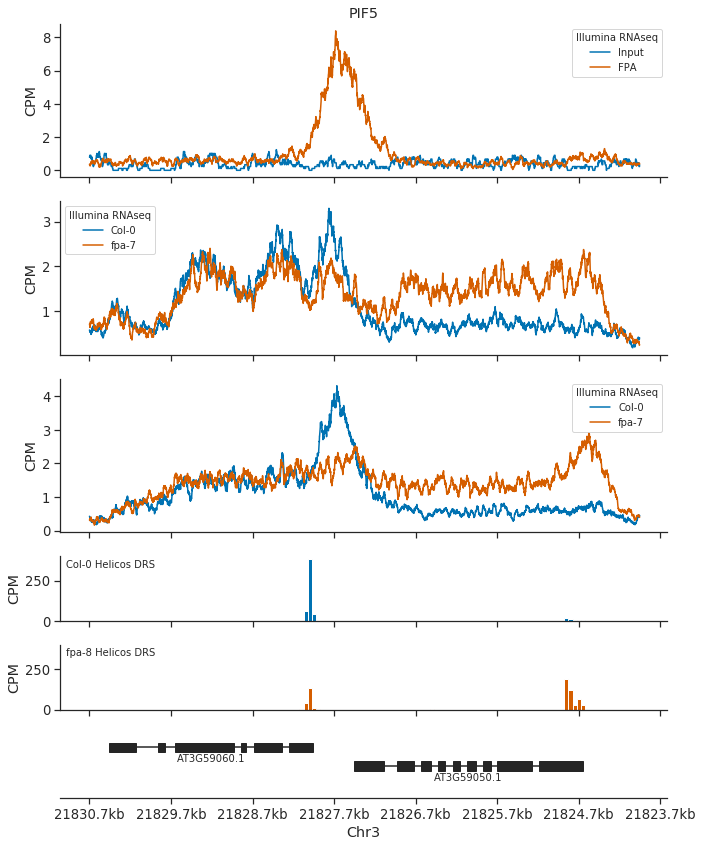

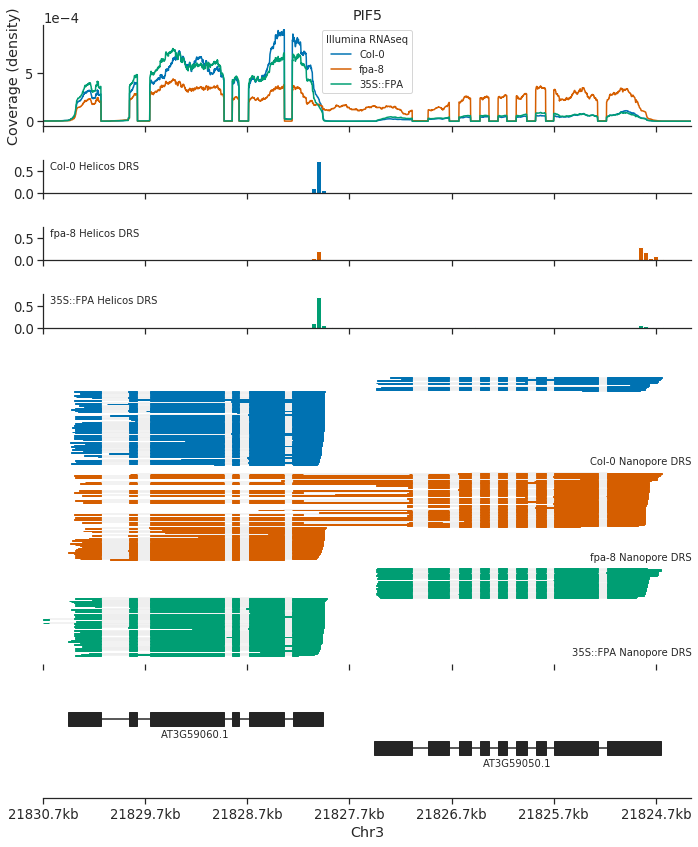

In [12]:
plot_fpa_polii_chipseq(
    query=('3', 21824000, 21830748, '-'),
    annot_whitelist=['AT3G59060.1', 'AT3G59050.1'],
    title='PIF5',
    figsize=(10, 12),
    illumina_rows=2,
    helicos_binsize=50,
)

plt.savefig('figures/pif5_chipseq.svg')
plt.show()

plot_nanopore_helicos_illumina(
    query=('3', 21824400, 21830748, '-'),
    annot_whitelist=['AT3G59060.1', 'AT3G59050.1'],
    title='PIF5',
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
    annot_rows=2
)
plt.savefig('figures/pif5.svg')

plt.show()

## FPA

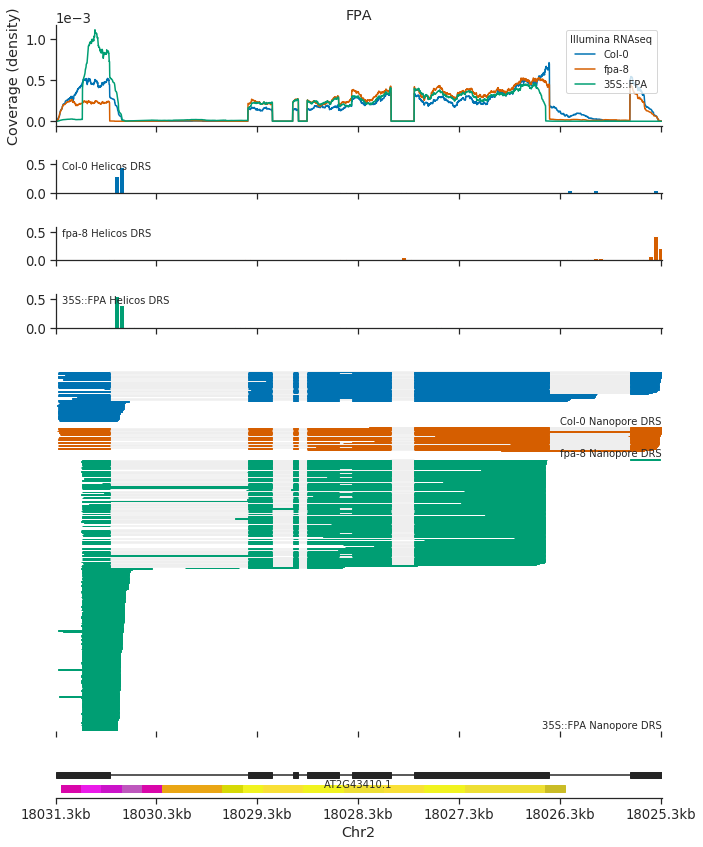

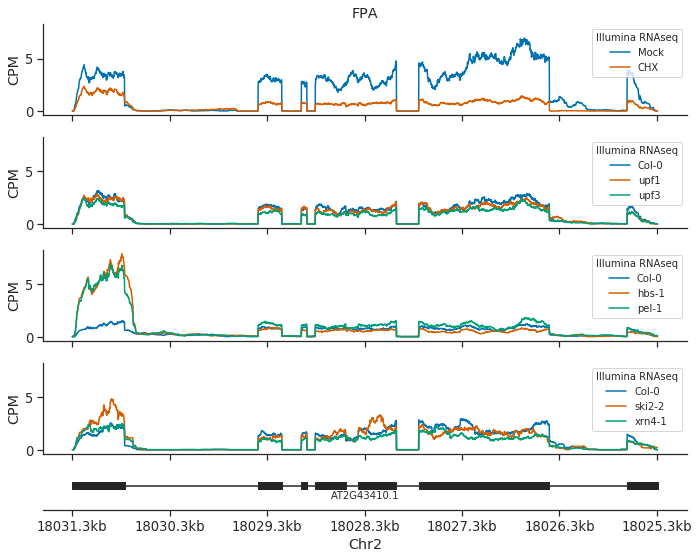

In [30]:
plot_nanopore_helicos_illumina(
    query=('2', 18025247, 18031255, '-'),
    annot_whitelist=['AT2G43410.1', 'AT4G12640.2'],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=6,
    title='FPA',
    helicos_binsize=50,
    nanopore_sample_size=500,
    illumina_y='Coverage (density)',
)
plt.savefig('figures/fpa.svg')
plt.show()

plot_decay_factor_illumina(
    query=('2', 18025247, 18031255, '-'),
    annot_whitelist=['AT2G43410.1', 'AT4G12640.2'],
    figsize=(10, 8),
    title='FPA',
)
plt.show()

## IBM1

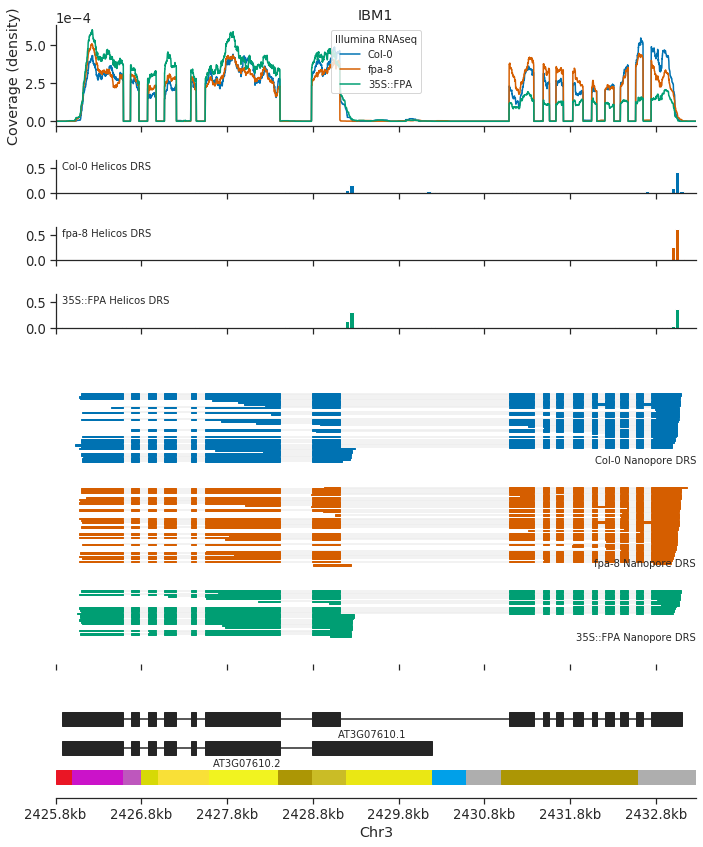

In [14]:
plot_nanopore_helicos_illumina(
    query=('3', 2425809, 2433279, '+'),
    annot_whitelist=['AT3G07610.1', 'AT3G07610.2'],
    figsize=(10, 12),
    illumina_rows=2,
    annot_rows=2,
    nanopore_rows=5,
    title='IBM1',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)'
)
plt.savefig('figures/ibm1.svg')

plt.show()

## CFIS2

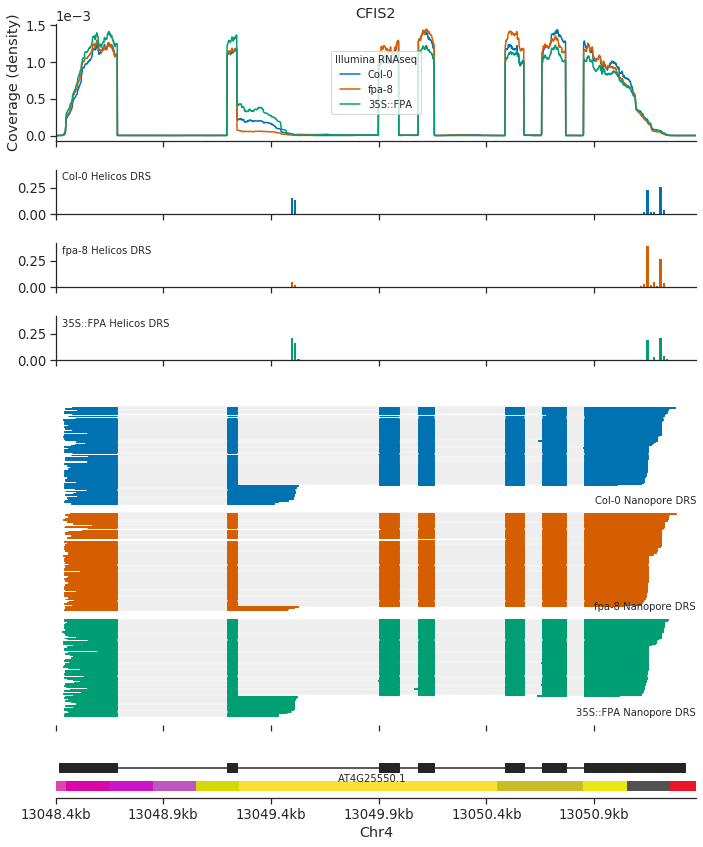

In [33]:
plot_nanopore_helicos_illumina(
    query=('4', 13048350, 13051323, '+'),
    annot_whitelist=['AT4G25550.1',],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    title='CFIS2',
    helicos_binsize=15,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)'
)
plt.savefig('figures/cfis2.svg')

plt.show()

## CPSF160

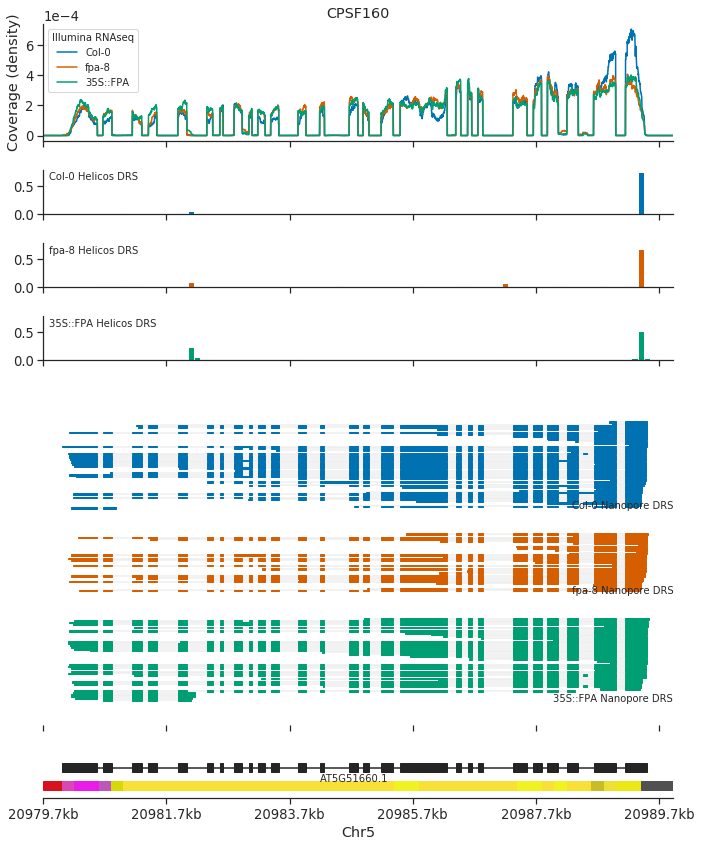

In [16]:
plot_nanopore_helicos_illumina(
    query=('5', 20979700, 20989927, '+'),
    annot_whitelist=['AT5G51660.1',],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    title='CPSF160',
    helicos_binsize=100,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)'
)
plt.savefig('figures/cpsf160.svg')
plt.show()

## CPSF73-1

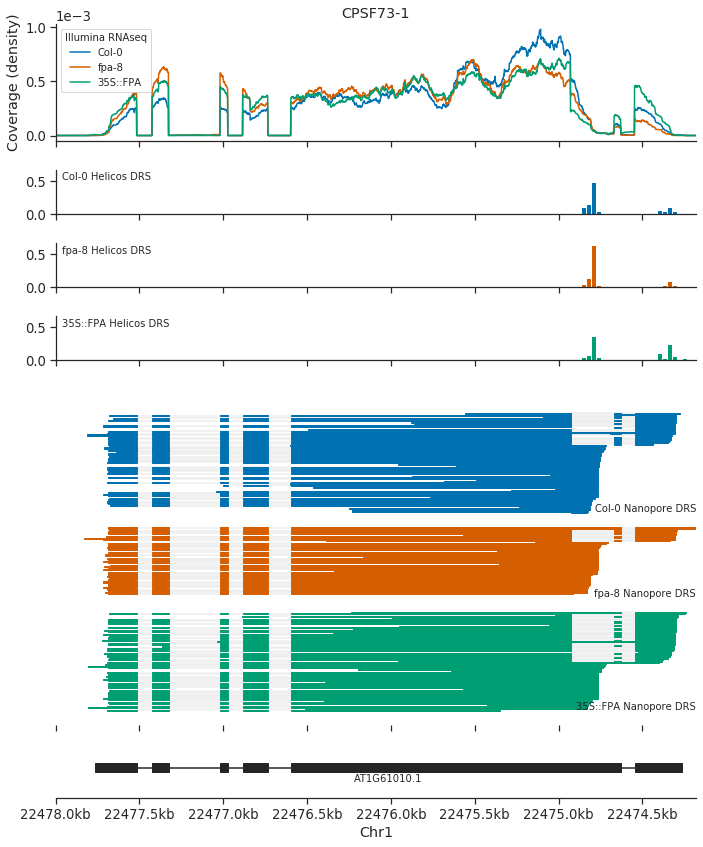

In [17]:
plot_nanopore_helicos_illumina(
    query=('1', 22474180, 22478000, '-'),
    annot_whitelist=['AT1G61010.1',],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    title='CPSF73-1',
    helicos_binsize=30,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False
)
plt.savefig('figures/cpsf73-1.svg')
plt.show()

## PCFS1

/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


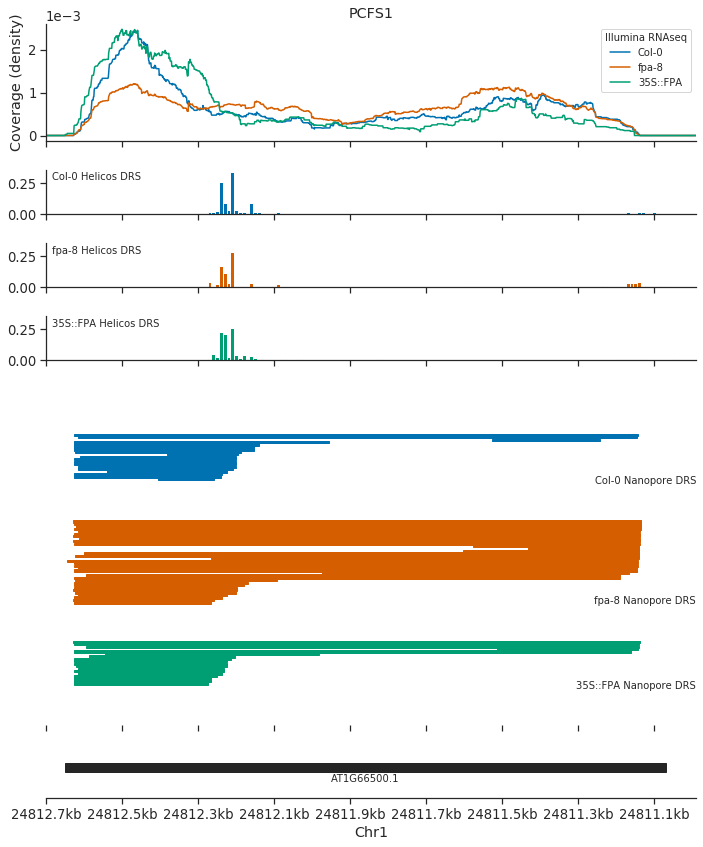

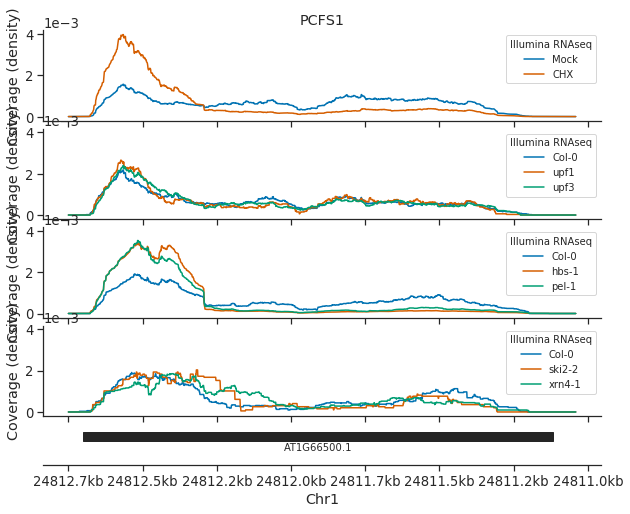

In [18]:
plot_nanopore_helicos_illumina(
    query=('1', 24811000, 24812710, '-'),
    annot_whitelist=['AT1G66500.1',],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    title='PCFS1',
    helicos_binsize=10,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)
plt.savefig('figures/pcfs1.svg')

plot_decay_factor_illumina(
    query=('1', 24811000, 24812710, '-'),
    annot_whitelist=['AT1G66500.1',],
    title='PCFS1',
    figsize=(10, 8),
    illumina_y='Coverage (density)'
)

plt.savefig('figures/pcfs1_nmd_nsd.svg')

plt.show()

## PCFS5

/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


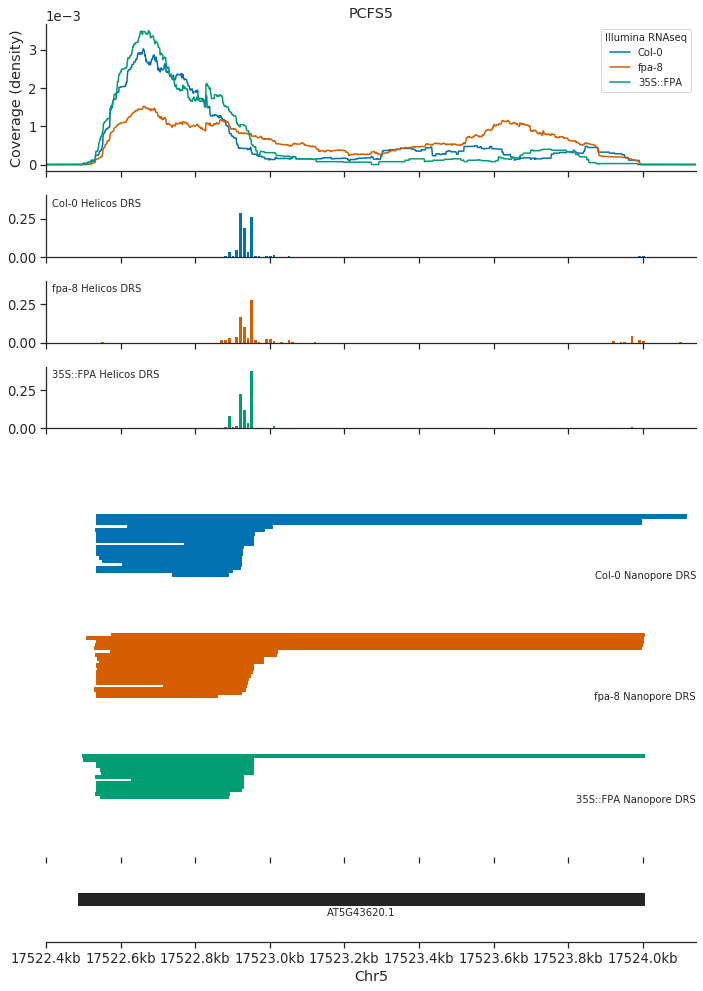

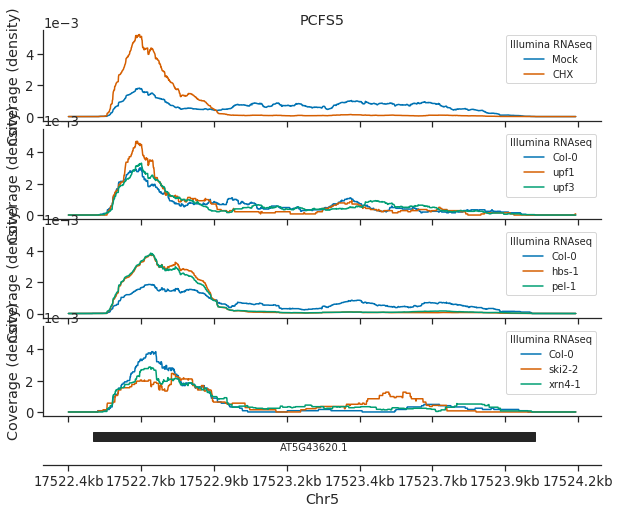

In [19]:
plot_nanopore_helicos_illumina(
    query=('5', 17522400, 17524143, '+'),
    annot_whitelist=['AT5G43620.1',],
    figsize=(10, 14),
    illumina_rows=2,
    nanopore_rows=5,
    title='PCFS5',
    helicos_binsize=10,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)
plt.savefig('figures/pcfs5.svg')

plot_decay_factor_illumina(
    query=('5', 17522400, 17524143, '+'),
    annot_whitelist=['AT5G43620.1',],
    title='PCFS5',
    figsize=(10, 8),
    illumina_y='Coverage (density)'
)

plt.savefig('figures/pcfs5_nmd_nsd.svg')

plt.show()

## RSA1

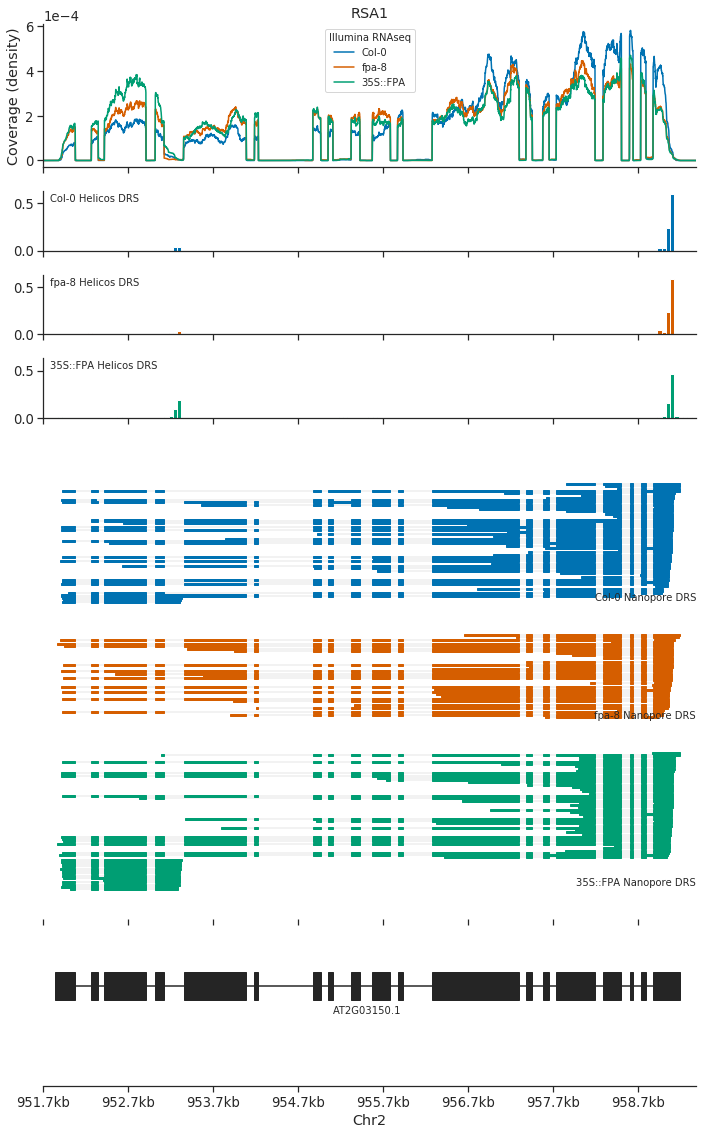

In [20]:
plot_nanopore_helicos_illumina(
    query=('2', 951744, 959423, '+'),
    annot_whitelist=['AT2G03150.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=6,
    annot_rows=2,
    title='RSA1',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)
plt.savefig('figures/rsa1.svg')

plt.show()

## BORDER1

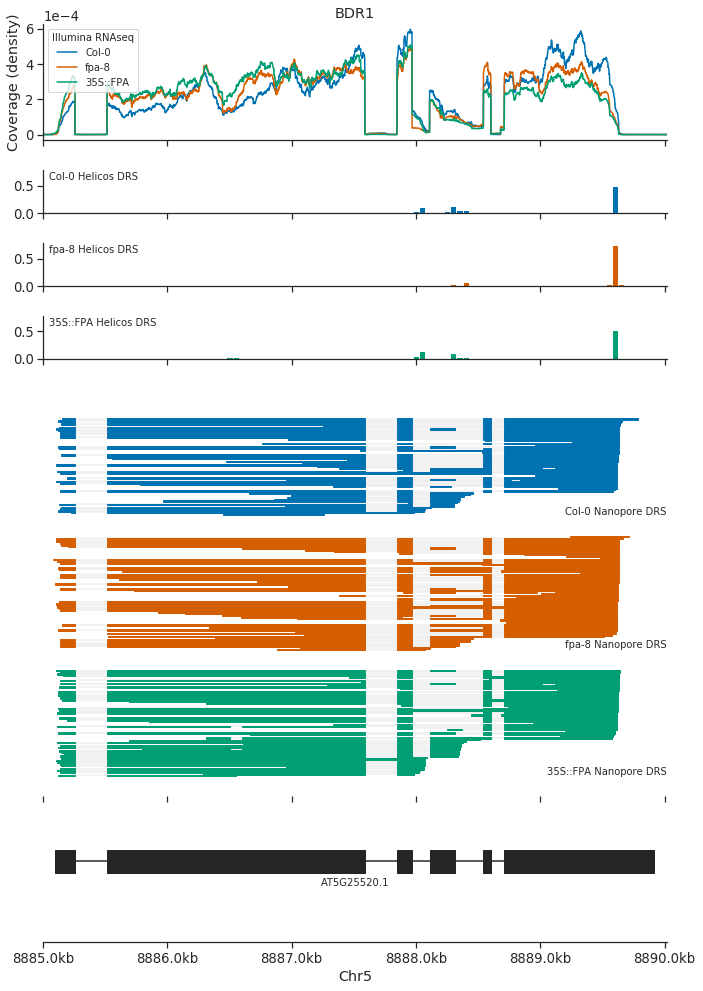

In [21]:
plot_nanopore_helicos_illumina(
    query=('5', 8884988, 8890005, '+'),
    annot_whitelist=['AT5G25520.1',],
    figsize=(10, 14),
    illumina_rows=2,
    nanopore_rows=6,
    annot_rows=2,
    title='BDR1',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)
plt.savefig('figures/bdr1.svg')

plt.show()

# BDR2

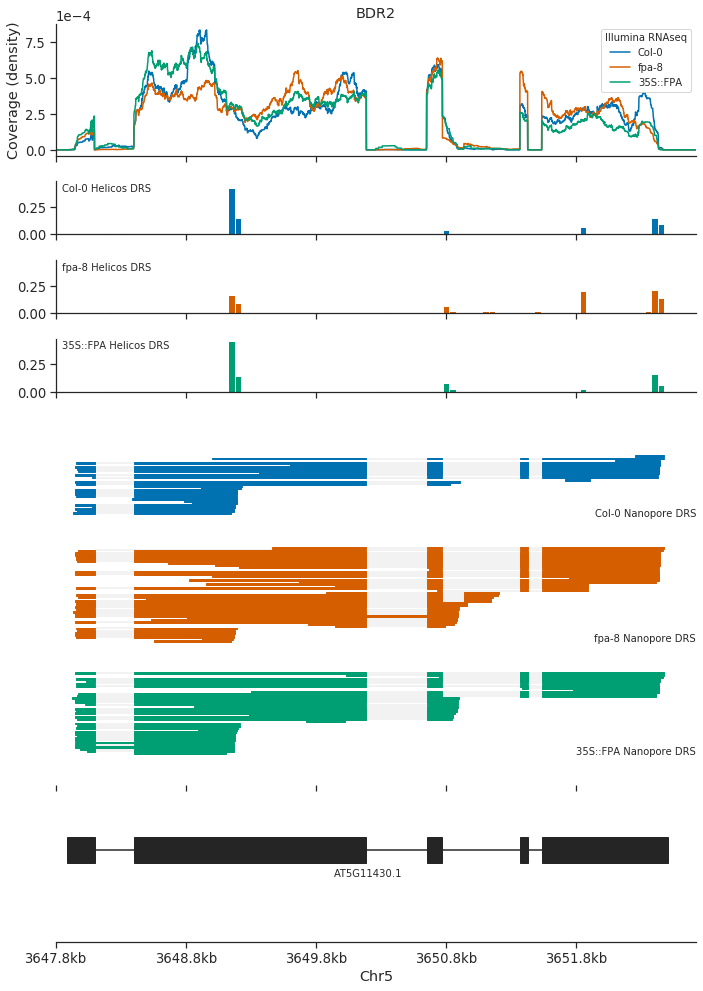

In [22]:
plot_nanopore_helicos_illumina(
    query=('5', 3647772, 3652691, '+'),
    annot_whitelist=['AT5G11430.1', ],
    figsize=(10, 14),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='BDR2',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)
plt.savefig('figures/bdr2.svg')

plt.show()

## AtSPEN2

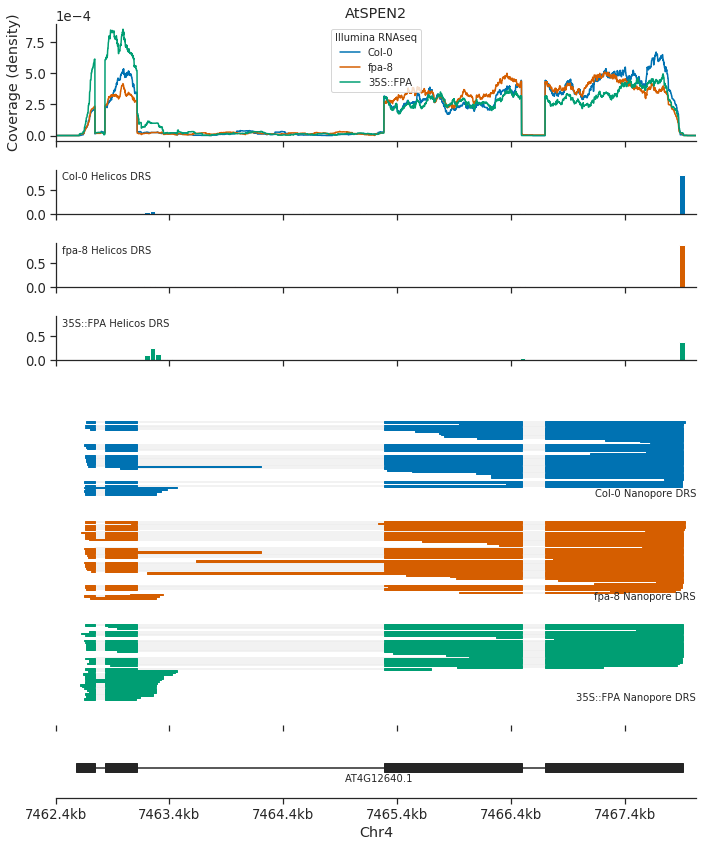

In [23]:
plot_nanopore_helicos_illumina(
    query=('4', 7462353, 7467976, '+'),
    annot_whitelist=['AT4G12640.1'],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=1,
    title='AtSPEN2',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)
plt.savefig('figures/atspen2.svg')
plt.show()

## AT5G46490

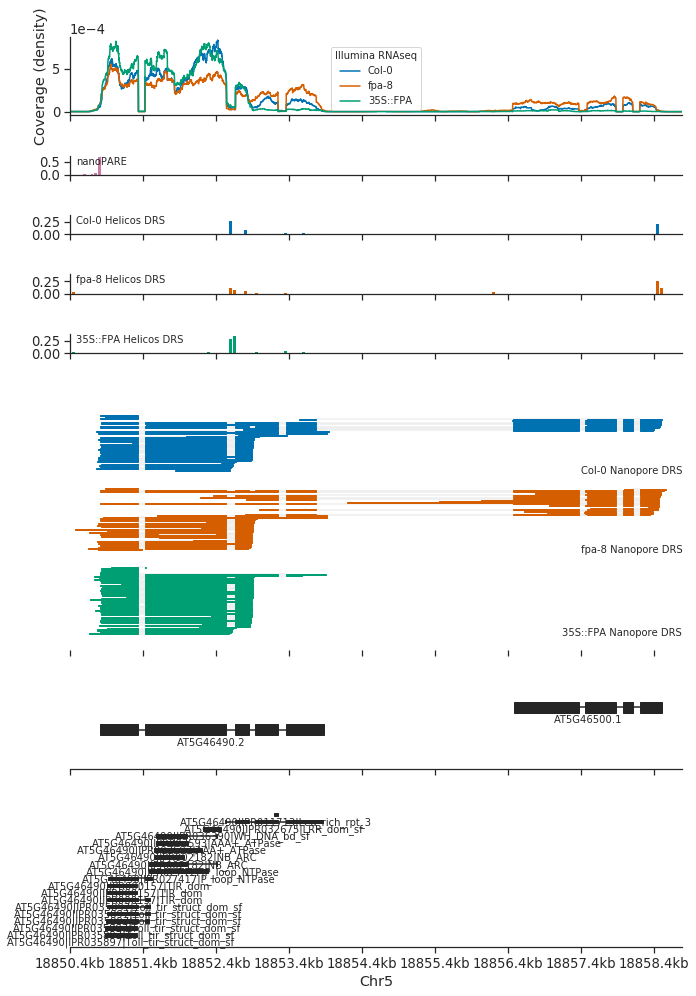

In [27]:
plot_nanopore_helicos_illumina(
    query=('5', 18850363, 18858754, '+'),
    annot_whitelist=['AT5G46490.2', 'AT5G46500.1'],
    figsize=(10, 14),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
    add_interpro=True,
    add_nanoPARE=True,
    interpro_rows=3,
)

plt.savefig('figures/AT5G46490.svg')

plt.show()

## AT1G72840

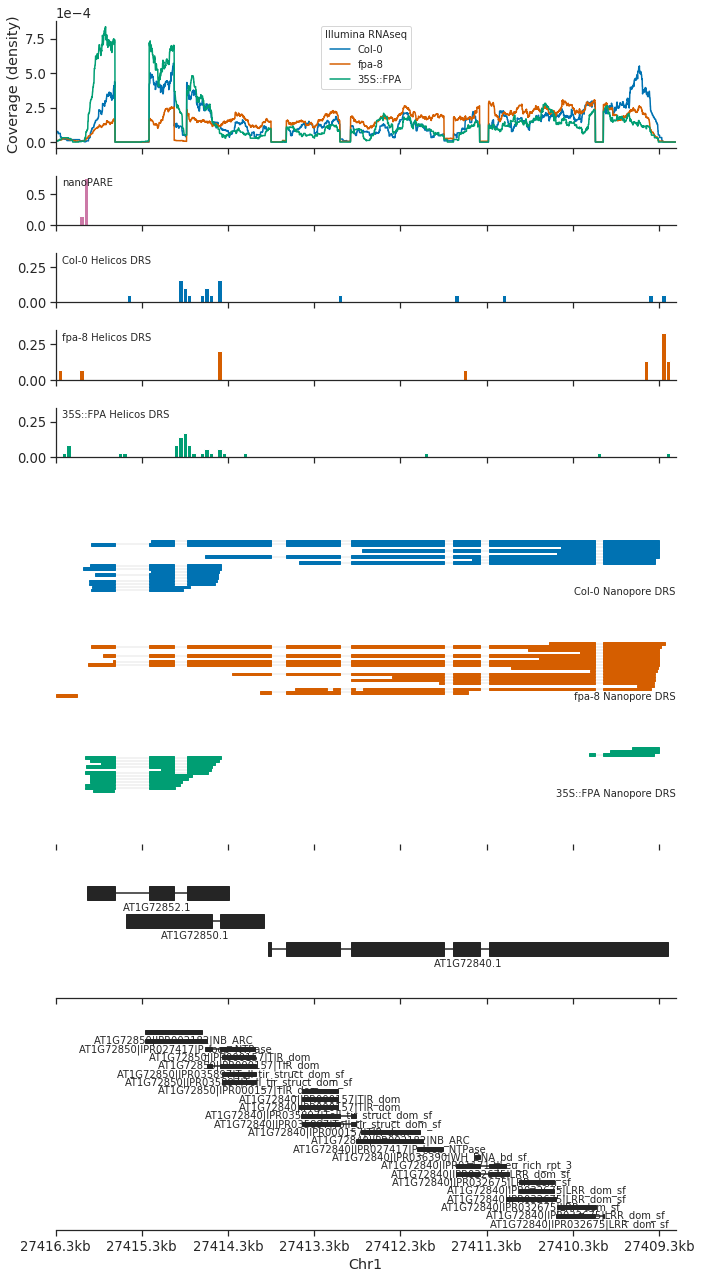

In [25]:
plot_nanopore_helicos_illumina(
    query=('1', 27409109, 27416300, '-'),
    annot_whitelist=['AT1G72840.1', 'AT1G72852.1', 'AT1G72850.1'],
    figsize=(10, 18),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
    add_interpro=True,
    add_nanoPARE=True,
    interpro_rows=3,
)

plt.savefig('figures/AT1G72840.svg')

plt.show()

# AT1G58848

/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


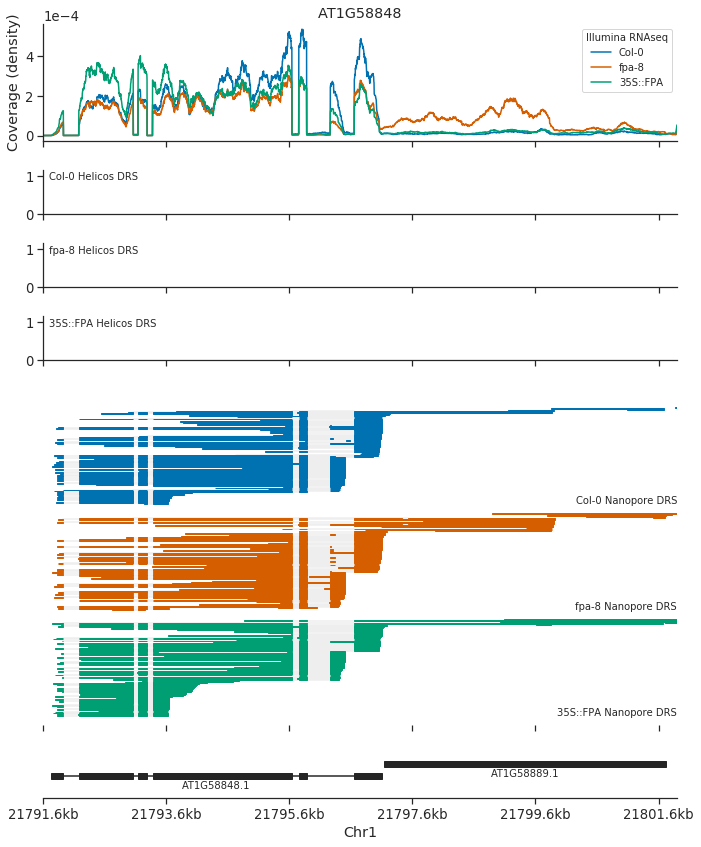

In [26]:
plot_nanopore_helicos_illumina(
    query=('1', 21791551, 21801850, '+'),
    annot_whitelist=['AT1G58848.1', 'AT1G58889.1'],
    extra_annot=[('AT1G58889.1', [[5537, 10118]])],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=1,
    title='AT1G58848',
    helicos_binsize=500,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)

plt.savefig('figures/AT1G58848.svg')
plt.show()

# AT1G63730

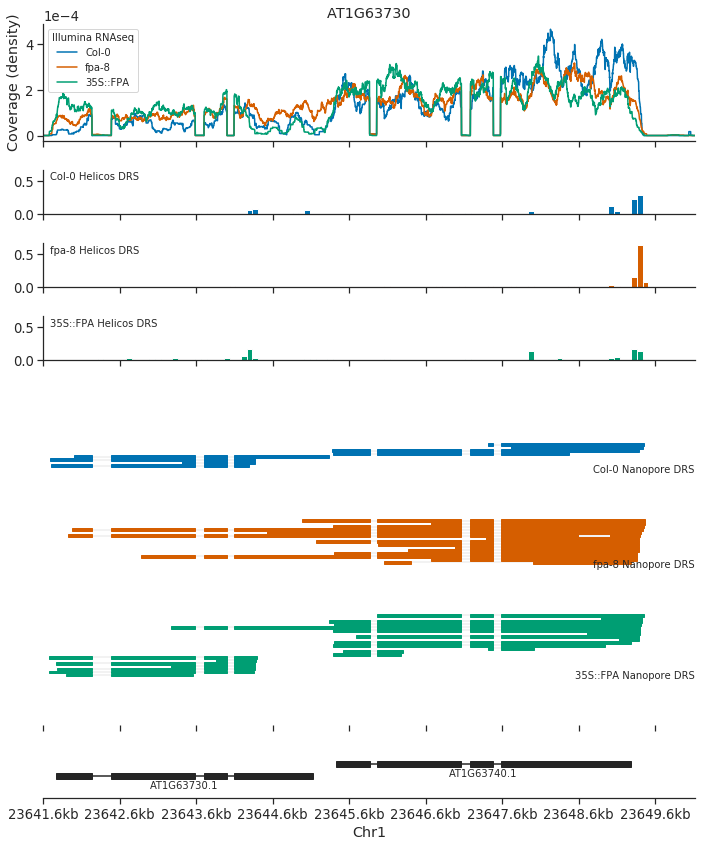

In [30]:
plot_nanopore_helicos_illumina(
    query=('1', 23641600, 23650120, '+'),
    annot_whitelist=['AT1G63730.1', 'AT1G63740.1'],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=1,
    title='AT1G63730',
    helicos_binsize=75,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)

plt.savefig('figures/AT1G63730.svg')

plt.show()

# AT1G12210

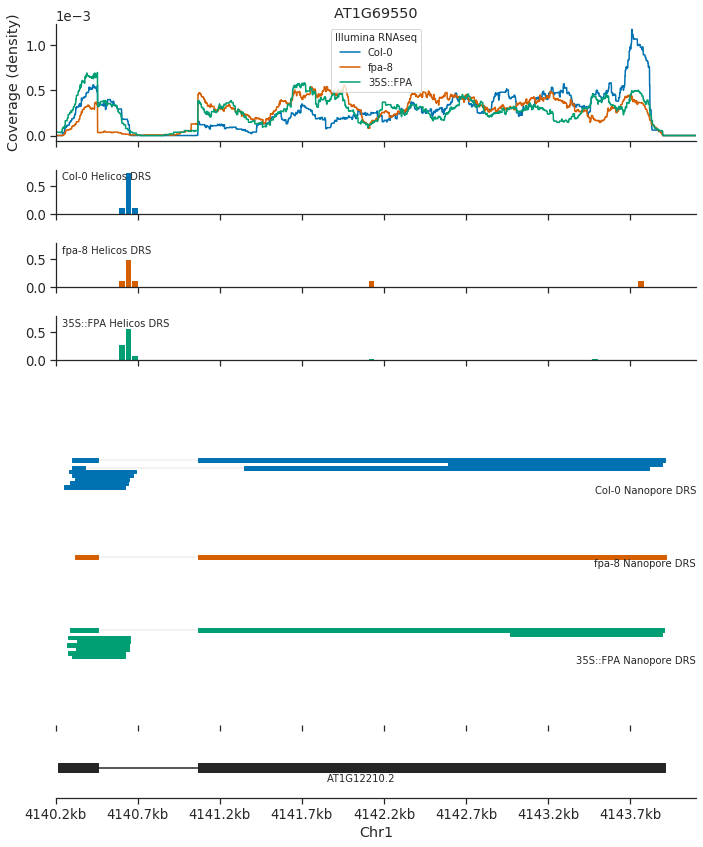

In [31]:
plot_nanopore_helicos_illumina(
    query=('1', 4140200, 4144100, '+'),
    annot_whitelist=['AT1G12210.2'],
    figsize=(10, 12),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=1,
    title='AT1G69550',
    helicos_binsize=40,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
)

plt.savefig('figures/AT1G12210.svg')

plt.show()

# AT1G69550

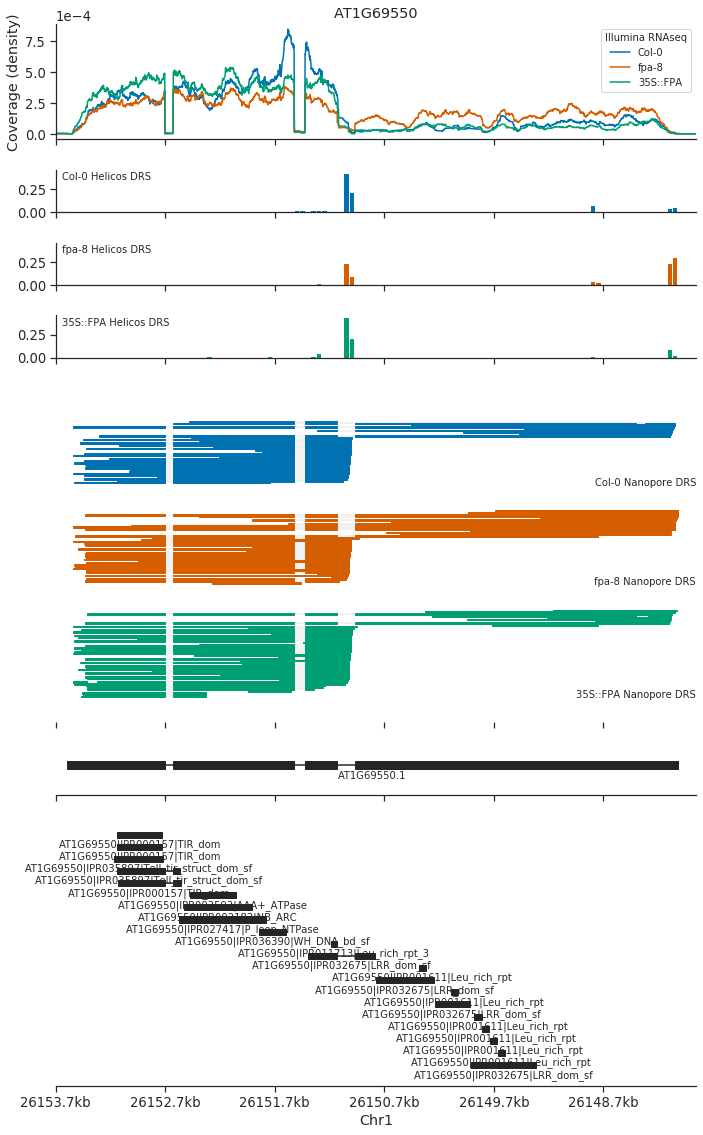

In [32]:
plot_nanopore_helicos_illumina(
    query=('1', 26147855, 26153700, '-'),
    annot_whitelist=['AT1G69550.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=1,
    title='AT1G69550',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
    add_interpro=True,
    interpro_rows=4
)

plt.savefig('figures/AT1G69550.svg')

plt.show()

## RPS4

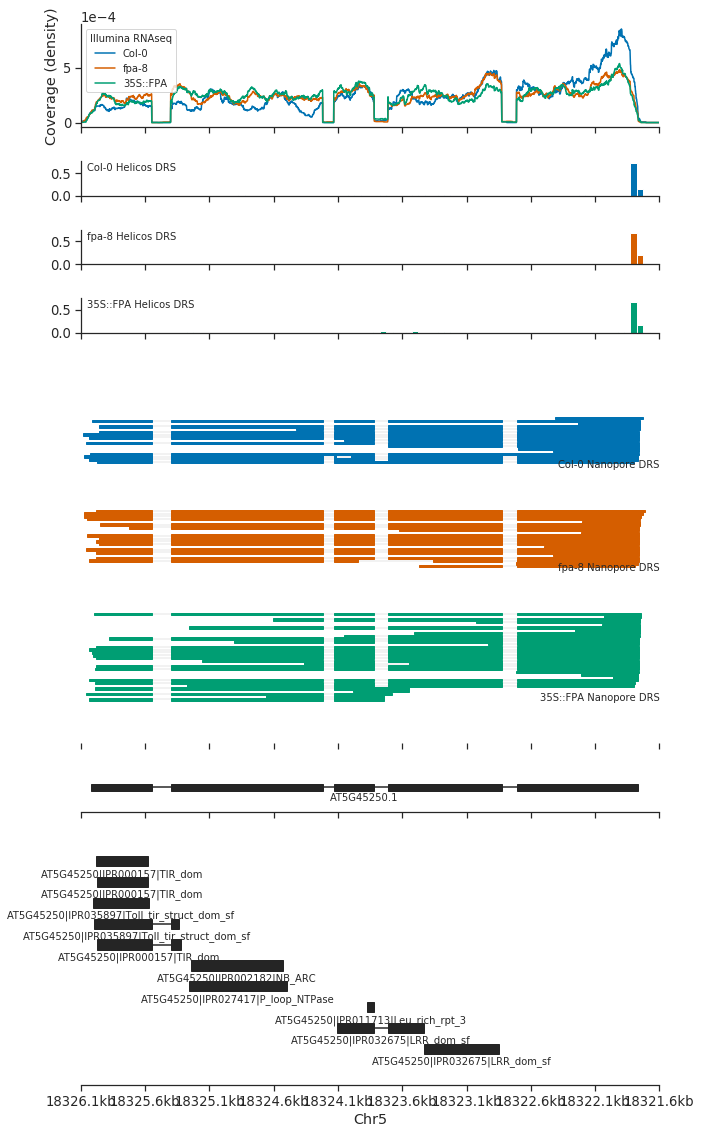

In [132]:
plot_nanopore_helicos_illumina(
    query=('5', 18321600, 18326100, '-'),
    annot_whitelist=['AT5G45250.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=6,
    annot_rows=1,
    title='',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
    add_interpro=True,
    interpro_rows=4
)

plt.savefig('figures/rps4.svg')

plt.show()

# AT2G14080

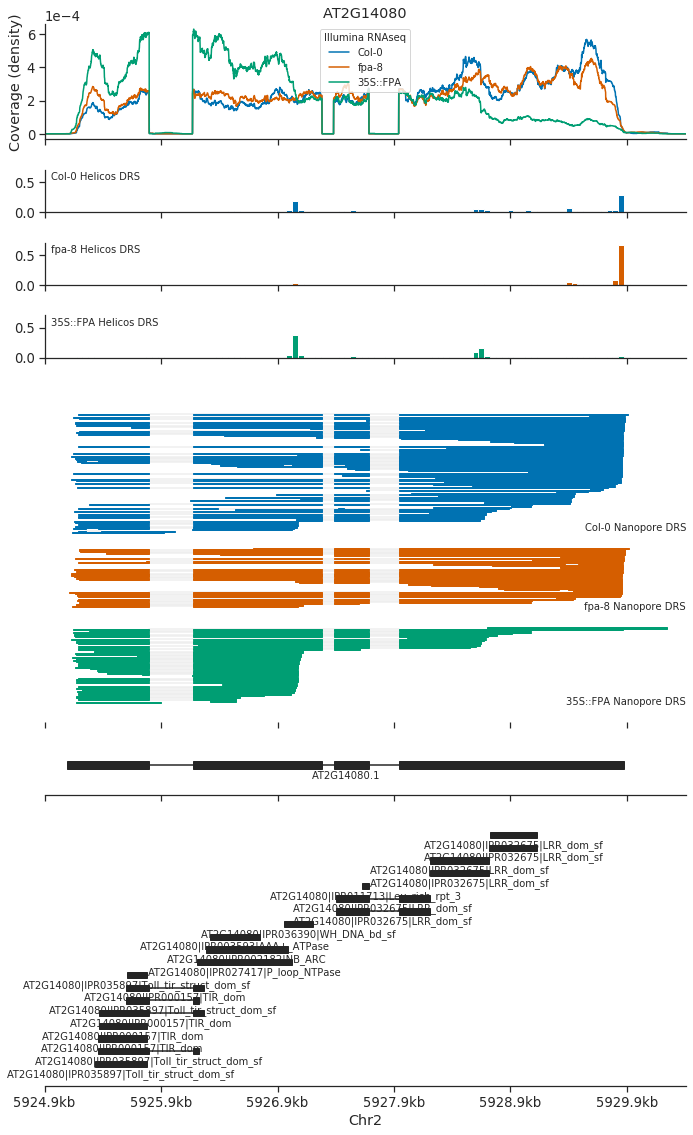

In [28]:
plot_nanopore_helicos_illumina(
    query=('2', 5924924, 5930432, '+'),
    annot_whitelist=['AT2G14080.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=1,
    title='AT2G14080',
    helicos_binsize=50,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_chromatin_state=False,
    add_interpro=True,
    interpro_rows=4
)

plt.savefig('figures/AT2G14080.svg')

plt.show()

## LOV1

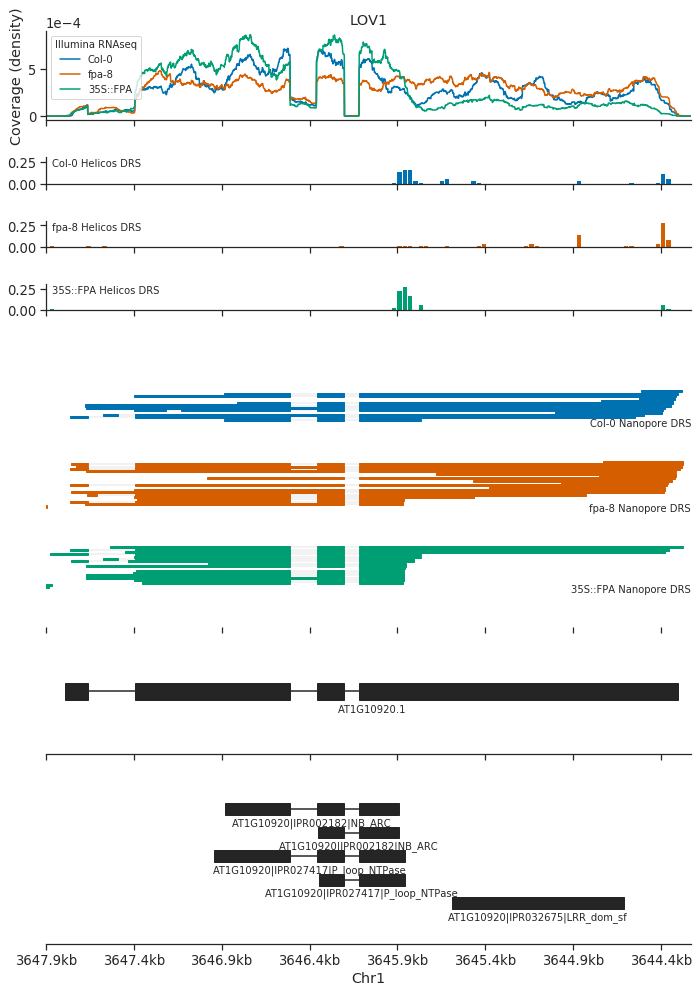

In [114]:
plot_nanopore_helicos_illumina(
    query=('1', 3644221, 3647892, '-'),
    annot_whitelist=['AT1G10920.1',],
    figsize=(10, 14),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='LOV1',
    helicos_binsize=30,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_interpro=True,
    add_chromatin_state=False,
    interpro_rows=3,
)
plt.savefig('figures/lov1.svg')

plt.show()

# RPP13

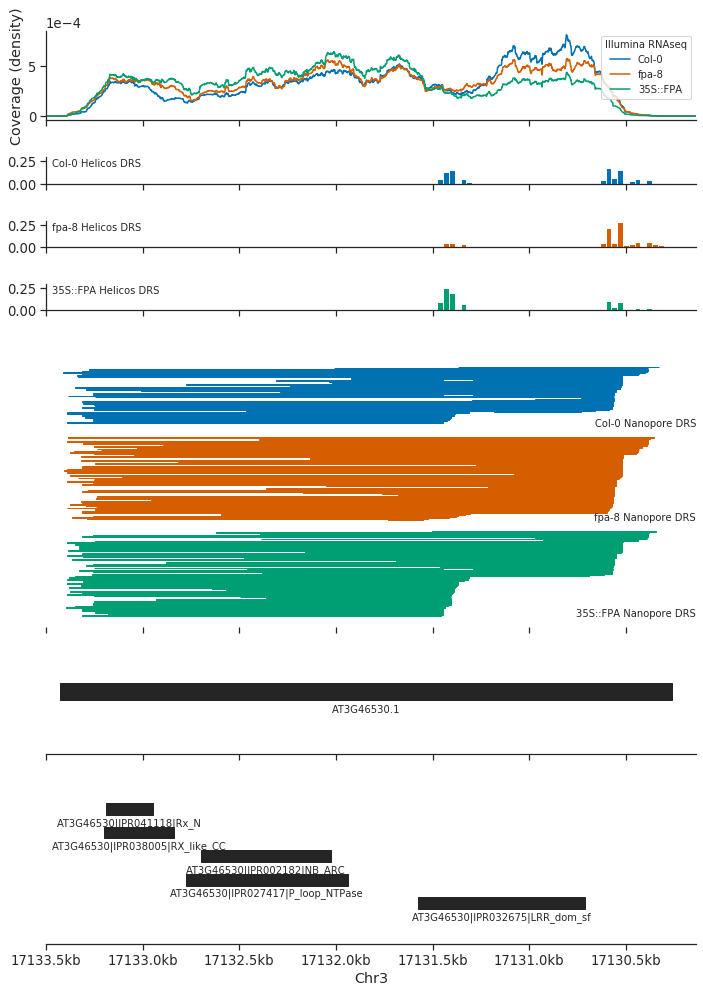

In [115]:
plot_nanopore_helicos_illumina(
    query=('3', 17130173, 17133536, '-'),
    annot_whitelist=['AT3G46530.1',],
    figsize=(10, 14),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    helicos_binsize=30,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_interpro=True,
    add_chromatin_state=False,
    interpro_rows=3,
)
plt.savefig('figures/rpp13.svg')

plt.show()


## RPP7

/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


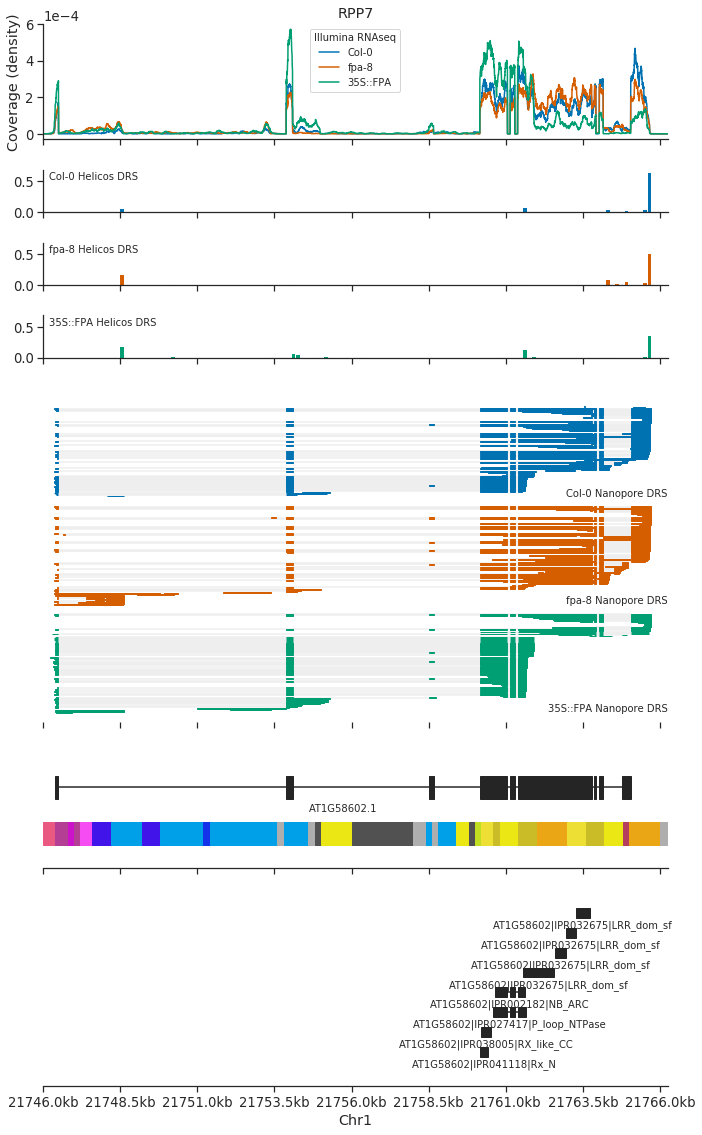

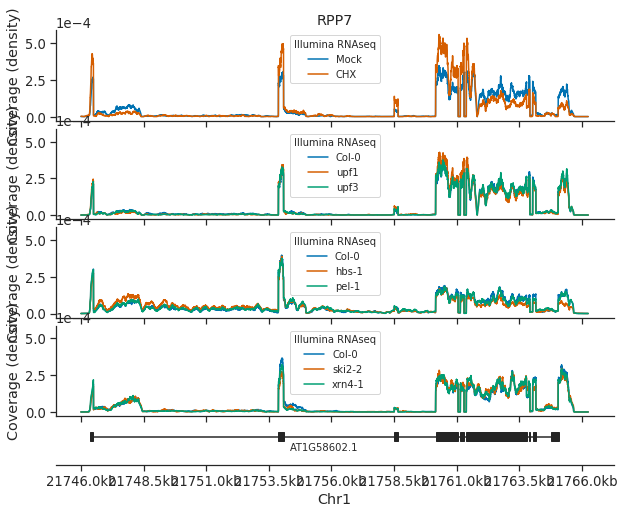

In [94]:
plot_nanopore_helicos_illumina(
    query=('1', 21746000, 21766251, '+'),
    annot_whitelist=['AT1G58602.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='RPP7',
    helicos_binsize=150,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_interpro=True,
    interpro_rows=3,
)
plt.savefig('figures/rpp7.svg')

plot_decay_factor_illumina(
    query=('1', 21746000, 21766251, '+'),
    annot_whitelist=['AT1G58602.1'],
    title='RPP7',
    figsize=(10, 8),
    annot_rows=1,
    illumina_y='Coverage (density)'
)

plt.savefig('figures/rpp7_nmd_nsd.svg')

plt.show()

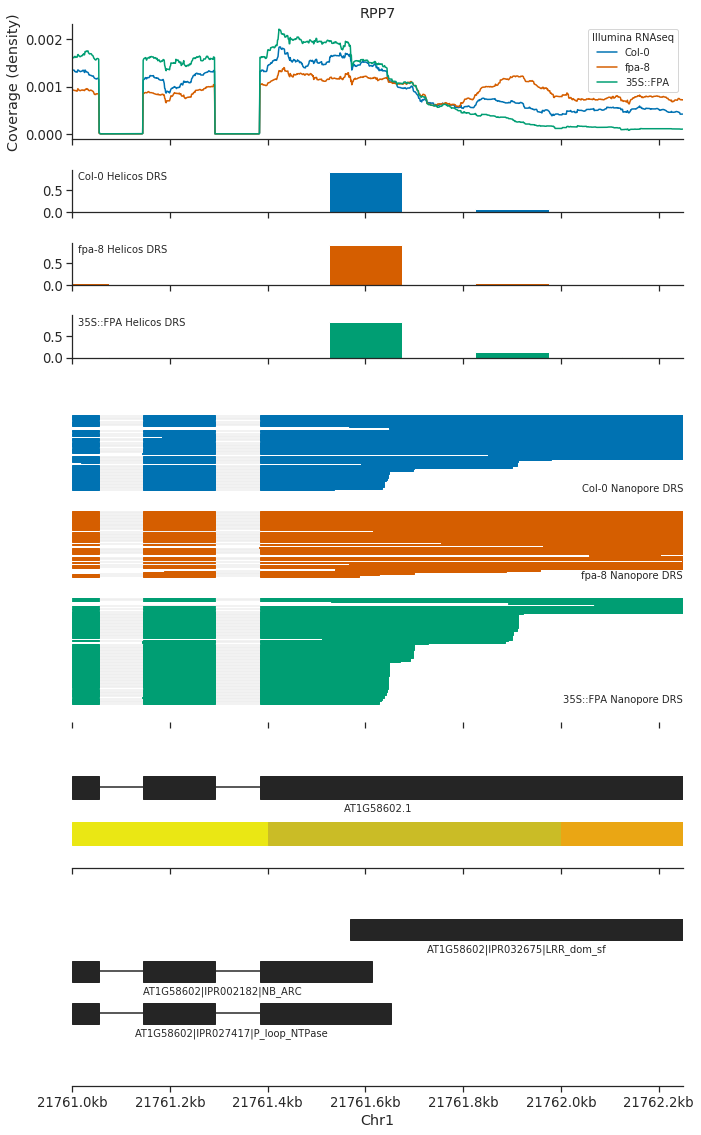

In [74]:
plot_nanopore_helicos_illumina(
    query=('1', 21761000, 21762250, '+'),
    annot_whitelist=['AT1G58602.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='RPP7',
    helicos_binsize=150,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_interpro=True,
    interpro_rows=3,
)
plt.savefig('figures/rpp7_exon6_zoomed.svg')

plt.show()

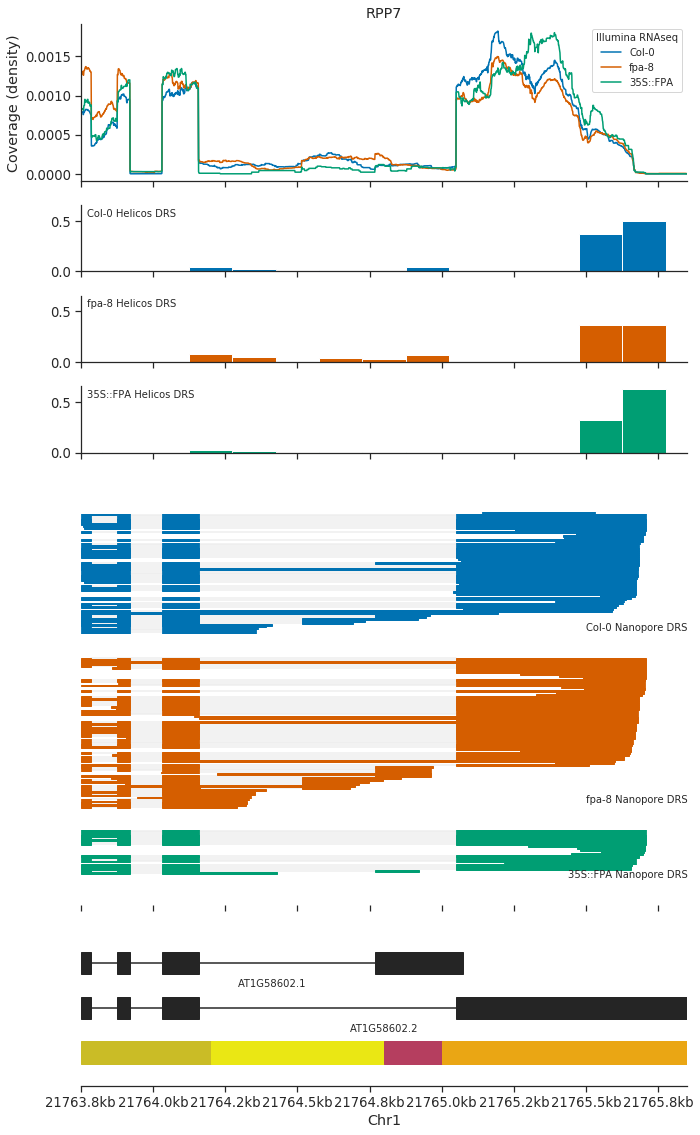

In [80]:
plot_nanopore_helicos_illumina(
    query=('1', 21763750, 21765850, '+'),
    annot_whitelist=['AT1G58602.1', 'AT1G58602.2'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='RPP7',
    helicos_binsize=150,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_interpro=False,
)
plt.savefig('figures/rpp7_utr_zoomed.svg')

plt.show()

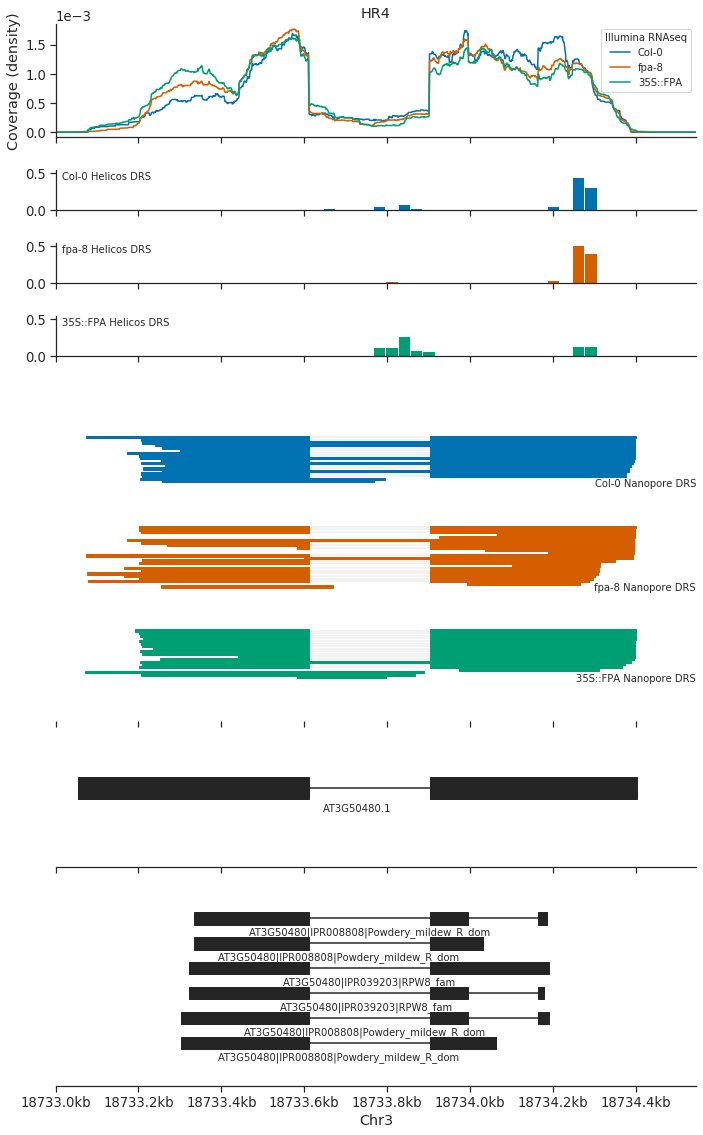

In [50]:
plot_nanopore_helicos_illumina(
    query=('3', 18732986, 18734531, '+'),
    annot_whitelist=['AT3G50480.1'],
    figsize=(10, 16),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='HR4',
    helicos_binsize=30,
    nanopore_sample_size=200,
    illumina_y='Coverage (density)',
    add_interpro=True,
    add_chromatin_state=False,
    interpro_rows=3,
)
plt.savefig('figures/hr4.svg')

plt.show()

# RPP4

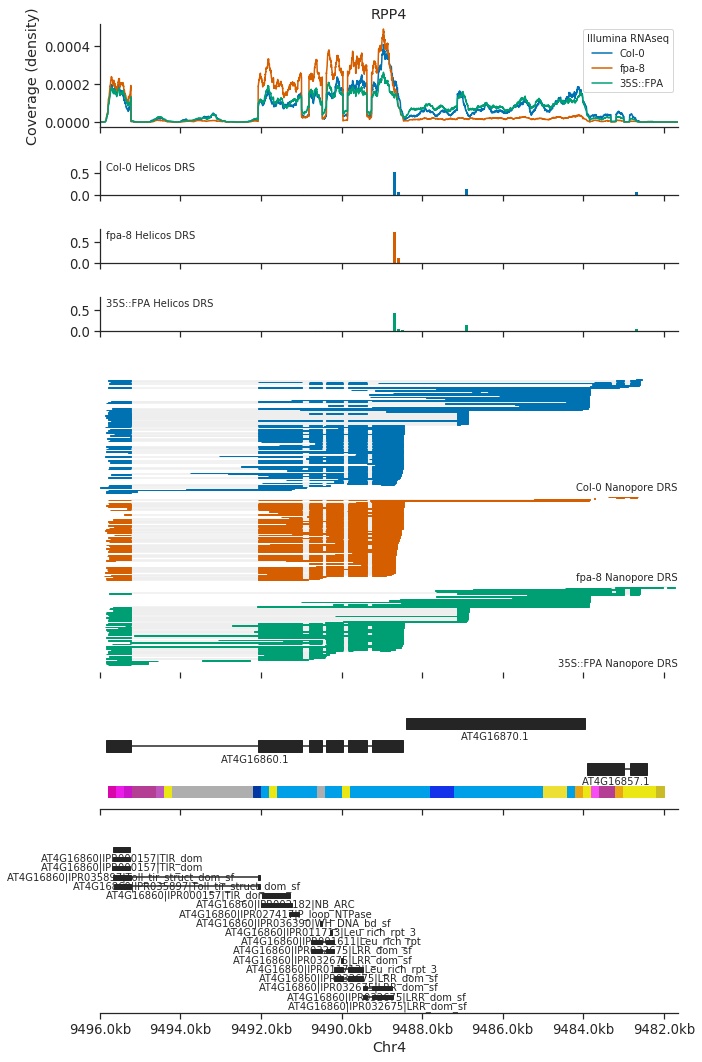

In [69]:
plot_nanopore_helicos_illumina(
    query=('4', 9481652, 9496000, '-'),
    annot_whitelist=['AT4G16860.1', 'AT4G16857.1',],
    extra_annot=[('AT4G16870.1', [[7603, 12_045]])],
    figsize=(10, 15),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='RPP4',
    helicos_binsize=100,
    nanopore_sample_size=200,
    add_interpro=True,
    interpro_rows=3,
    illumina_y='Coverage (density)'
)
plt.savefig('figures/rpp4.svg')
plt.show()

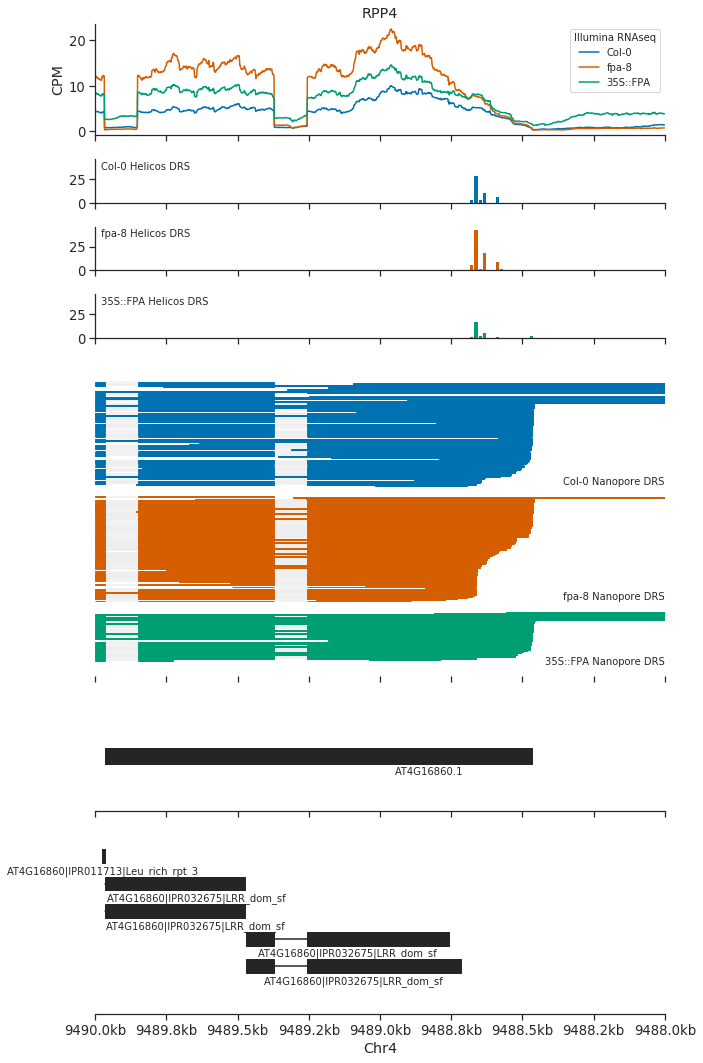

In [68]:
plot_nanopore_helicos_illumina(
    query=('4', 9488000, 9490000, '-'),
    annot_whitelist=['AT4G16860.1', 'AT4G16857.1',],
    extra_annot=[('AT4G16870.1', [[7603, 12_045]])],
    figsize=(10, 15),
    illumina_rows=2,
    nanopore_rows=5,
    annot_rows=2,
    title='RPP4',
    helicos_binsize=15,
    nanopore_sample_size=200,
    add_interpro=True,
    interpro_rows=3,
    illumina_y='CPM'
)
plt.savefig('figures/rpp4_zoomed.svg')
plt.show()

In [24]:
def plot_hen2_nanopore_helicos_illumina(query, annot_whitelist,
                                        figsize=(10, 15),
                                        nanopore_rows=5,
                                        illumina_rows=2,
                                        helicos_rows=1,
                                        annot_rows=1,
                                        extra_annot=None,
                                        interpro_rows=1,
                                        title=None,
                                        helicos_binsize=100,
                                        nanopore_sample_size=200,
                                        illumina_y='Coverage (density)',
                                        add_chromatin_state=True,
                                        add_interpro=False,
                                        add_nanoPARE=False):

    assert illumina_y in ['CPM', 'Coverage (density)']

    s = 'fwd' if query[3] == '+' else 'rev'

    fig = plt.figure(figsize=figsize)
    interpro_rows = 0 if not add_interpro else interpro_rows
    nanoPARE_rows = 0 if not add_nanoPARE else helicos_rows
    grid = (nanopore_rows + nanoPARE_rows + 3 * helicos_rows + illumina_rows + annot_rows + interpro_rows, 1)

    illumina_ax = plt.subplot2grid(grid, loc=(0, 0), rowspan=illumina_rows)

    plot_illumina(
        [
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/col0.cpm.{s}.bw',
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/fpa8.cpm.{s}.bw',
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/35SFPA.cpm.{s}.bw',
        ],
        [
            'Col-0', 'fpa-8', '35S::FPA'
        ],
        pal[:3],
        *query,
        ax=illumina_ax,
        y_norm=illumina_y,
    )

    plt.setp(illumina_ax.get_xticklabels(), visible=False)
    illumina_ax.set_ylabel(illumina_y)
    sns.despine(ax=illumina_ax)

    if add_nanoPARE:
        nanoPARE_ax = plt.subplot2grid(grid, (illumina_rows, 0), sharex=illumina_ax)
        plot_helicos(
            f'../../../nanoPARE/coverage_tracks/5P/pooled.capped.5{s}_genomecov.bw',
            pal[4],  *query, binsize=helicos_binsize, label='nanoPARE', ax=nanoPARE_ax,
            y_norm=illumina_y,
        )
        plt.setp(nanoPARE_ax.get_xticklabels(), visible=False)
        sns.despine(ax=nanoPARE_ax, top=True, right=True)
        illumina_rows += nanoPARE_rows

    helicos_ax = None

    helicos_grid = [
        illumina_rows + helicos_rows * i for i in range(3)
    ]

    helicos_axes = []
    for sn, label, colour, i in zip(['col0', 'fpa8', '35SFPA'],
                                    ['Col-0 Helicos DRS',
                                     'fpa-8 Helicos DRS',
                                     '35S::FPA Helicos DRS'],
                                    pal[:3], helicos_grid):
        helicos_ax = plt.subplot2grid(grid, (i, 0), sharex=illumina_ax, sharey=helicos_ax)
        plot_helicos(
            f'../helicos_apa_pipeline/pipeline/coverage_tracks/{sn}.cpm.{s}.bw',
            colour,  *query, binsize=helicos_binsize, label=label, ax=helicos_ax,
            y_norm=illumina_y,
        )
        plt.setp(helicos_ax.get_xticklabels(), visible=False)
        #helicos_ax.set_ylabel(illumina_y)
        sns.despine(ax=helicos_ax, top=True, right=True)
        helicos_axes.append(helicos_ax)

    nanopore_row_start = i + helicos_rows
    nanopore_ax = plt.subplot2grid(grid,
                                   (nanopore_row_start, 0),
                                   rowspan=nanopore_rows,
                                   sharex=illumina_ax)

    plot_nanopore(
        ['../nanopore_apa_pipeline/pipeline/aligned_data/pooled/col0.bam',
         '../nanopore_apa_pipeline/pipeline/aligned_data/pooled/fpa8.bam',
         '../nanopore_apa_pipeline/pipeline/aligned_data/pooled/35SFPA.bam',
         '../../two_pass/two_pass_alignment_pipeline/pipeline/arabidopsis_hen2_drs/201812_hen2-2_run001_tissue2322/aligned_data/201901_hen2_1.real.refguided.bam'],
        ['Col-0 Nanopore DRS', 'fpa-8 Nanopore DRS', '35S::FPA Nanopore DRS', 'hen2-2 Nanopore DRS'],
        pal[:4],
        *query,
        sample_size=nanopore_sample_size,
        ax=nanopore_ax,
        ypad=20
    )
    sns.despine(ax=nanopore_ax, top=True, right=True, left=True, bottom=True)
    nanopore_ax.set_yticks([])
    plt.setp(nanopore_ax.get_xticklabels(), visible=False)

    annot_row_start = nanopore_row_start + nanopore_rows
    annot_ax = plt.subplot2grid(grid,
                                (annot_row_start, 0),
                                rowspan=annot_rows,
                                sharex=illumina_ax)

    plot_annot(
        '../illumina_rnaseq_pipeline/annotations/Araport11_prot_coding_and_non_coding.bed.gz',
        '../illumina_rnaseq_pipeline/annotations/at_chromhmm_states_coloured.bed.gz',
        *query, annot_whitelist, ax=annot_ax, extra_annot=extra_annot,
        add_chromatin_state=add_chromatin_state
    )
    sns.despine(ax=annot_ax, top=True, right=True, left=True)
    annot_ax.set_yticks([])

    if add_interpro:
        interpro_row_start = annot_row_start + annot_rows
        interpro_ax = plt.subplot2grid(grid,
                                       (interpro_row_start, 0),
                                       rowspan=interpro_rows,
                                       sharex=illumina_ax)
        plot_interpro(
            '../nanopore_apa_pipeline/annotations/araport_interpro_mapping.bed.gz',
            *query, ax=interpro_ax
        )
        plt.setp(annot_ax.get_xticklabels(), visible=False)
        sns.despine(ax=interpro_ax, top=True, right=True, left=True)
        interpro_ax.set_yticks([])
        interpro_ax.set_xticklabels(get_xticklabels(interpro_ax, query[1], query[2], query[3]))
        interpro_ax.set_xlabel(f'Chr{query[0]}')
        
    else:
        annot_ax.set_xticklabels(get_xticklabels(annot_ax, query[1], query[2], query[3]))
        annot_ax.set_xlabel(f'Chr{query[0]}')

    if title is not None:
        illumina_ax.set_title(title)
    plt.tight_layout()
    return fig, illumina_ax, helicos_axes, nanopore_ax, annot_ax

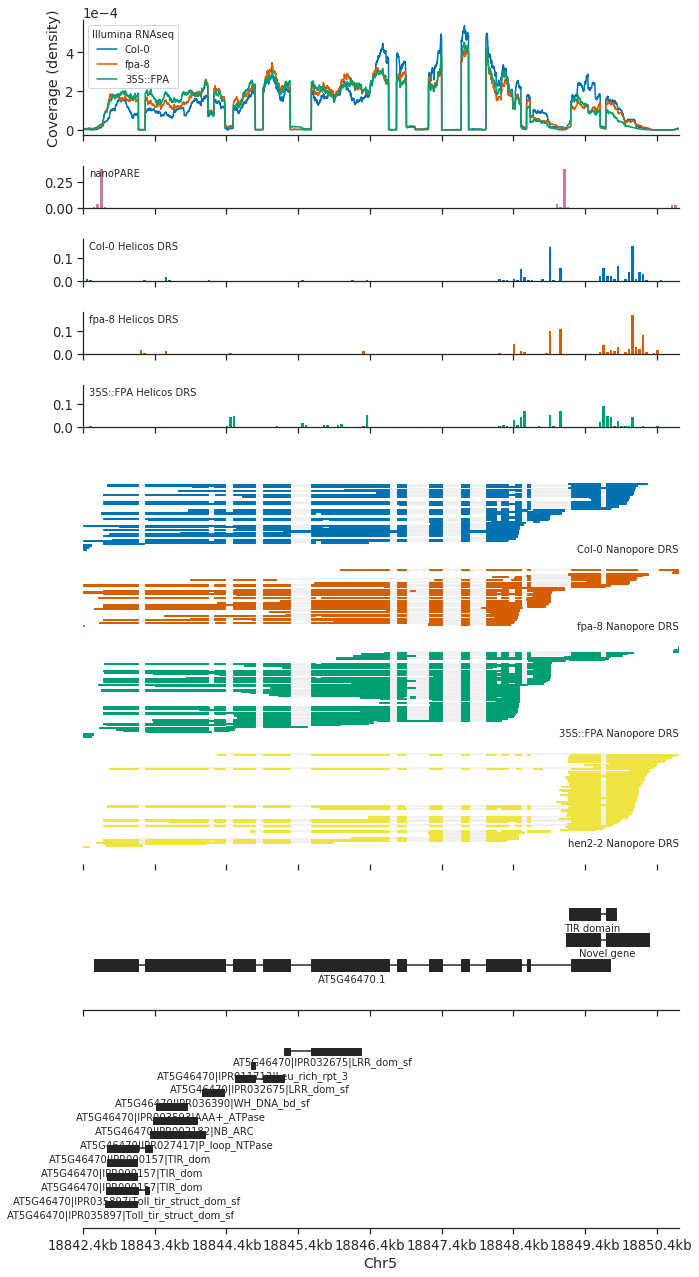

In [42]:
plot_hen2_nanopore_helicos_illumina(
    query=('5', 18842400, 18850700, '+'),
    annot_whitelist=['AT5G46470.1',],
    extra_annot=[('Novel gene', [[6729, 7209], [7287, 7883]]),
                 ('TIR domain', [[6776, 7209], [7287, 7425]])],
    figsize=(10, 18),
    nanopore_rows=6,
    annot_rows=2,
    nanopore_sample_size=200,
    helicos_binsize=50,
    add_nanoPARE=True,
    add_interpro=True,
    add_chromatin_state=False,
    interpro_rows=3,
    illumina_y='Coverage (density)'
)
plt.savefig('figures/rps6.svg')
plt.show()

In [54]:
def plot_vir1_nanopore_helicos_illumina(query, annot_whitelist,
                                        figsize=(10, 15),
                                        nanopore_rows=5,
                                        illumina_rows=2,
                                        helicos_rows=1,
                                        annot_rows=1,
                                        extra_annot=None,
                                        interpro_rows=1,
                                        title=None,
                                        helicos_binsize=100,
                                        nanopore_sample_size=200,
                                        illumina_y='Coverage (density)',
                                        add_chromatin_state=True,
                                        add_interpro=False,
                                        add_nanoPARE=False):

    assert illumina_y in ['CPM', 'Coverage (density)']

    s = 'fwd' if query[3] == '+' else 'rev'

    fig = plt.figure(figsize=figsize)
    interpro_rows = 0 if not add_interpro else interpro_rows
    nanoPARE_rows = 0 if not add_nanoPARE else helicos_rows
    grid = (nanopore_rows + nanoPARE_rows + 3 * helicos_rows + illumina_rows + annot_rows + interpro_rows, 1)

    illumina_ax = plt.subplot2grid(grid, loc=(0, 0), rowspan=illumina_rows)

    plot_illumina(
        [
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/col0.cpm.{s}.bw',
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/fpa8.cpm.{s}.bw',
            f'../illumina_rnaseq_pipeline/pipeline/coverage_tracks/pooled/35SFPA.cpm.{s}.bw',
        ],
        [
            'Col-0', 'fpa-8', '35S::FPA'
        ],
        pal[:3],
        *query,
        ax=illumina_ax,
        y_norm=illumina_y,
    )

    plt.setp(illumina_ax.get_xticklabels(), visible=False)
    illumina_ax.set_ylabel(illumina_y)
    sns.despine(ax=illumina_ax)

    if add_nanoPARE:
        nanoPARE_ax = plt.subplot2grid(grid, (illumina_rows, 0), sharex=illumina_ax)
        plot_helicos(
            f'../../../nanoPARE/coverage_tracks/5P/pooled.capped.5{s}_genomecov.bw',
            pal[4],  *query, binsize=helicos_binsize, label='nanoPARE', ax=nanoPARE_ax,
            y_norm=illumina_y,
        )
        plt.setp(nanoPARE_ax.get_xticklabels(), visible=False)
        sns.despine(ax=nanoPARE_ax, top=True, right=True)
        illumina_rows += nanoPARE_rows

    helicos_ax = None

    helicos_grid = [
        illumina_rows + helicos_rows * i for i in range(3)
    ]

    helicos_axes = []
    for sn, label, colour, i in zip(['col0', 'fpa8', '35SFPA'],
                                    ['Col-0 Helicos DRS',
                                     'fpa-8 Helicos DRS',
                                     '35S::FPA Helicos DRS'],
                                    pal[:3], helicos_grid):
        helicos_ax = plt.subplot2grid(grid, (i, 0), sharex=illumina_ax, sharey=helicos_ax)
        plot_helicos(
            f'../helicos_apa_pipeline/pipeline/coverage_tracks/{sn}.cpm.{s}.bw',
            colour,  *query, binsize=helicos_binsize, label=label, ax=helicos_ax,
            y_norm=illumina_y,
        )
        plt.setp(helicos_ax.get_xticklabels(), visible=False)
        #helicos_ax.set_ylabel(illumina_y)
        sns.despine(ax=helicos_ax, top=True, right=True)
        helicos_axes.append(helicos_ax)

    nanopore_row_start = i + helicos_rows
    nanopore_ax = plt.subplot2grid(grid,
                                   (nanopore_row_start, 0),
                                   rowspan=nanopore_rows,
                                   sharex=illumina_ax)

    plot_nanopore(
        ['../nanopore_apa_pipeline/pipeline/aligned_data/pooled/col0.bam',
         '../nanopore_apa_pipeline/pipeline/aligned_data/pooled/VIRc.bam',
         '../nanopore_apa_pipeline/pipeline/aligned_data/pooled/vir1.bam',
         '../../flacc/flacc_nanopore/pipeline/aligned_data/pooled/flacc.genome.bam',
         '../../flacc/flacc_nanopore/pipeline/aligned_data/'],
        ['Col-0 Nanopore DRS', 'VIRc Nanopore DRS', 'vir1-1 Nanopore DRS', 'flacc-1 Nanopore DRS'],
        pal[:4],
        *query,
        sample_size=nanopore_sample_size,
        ax=nanopore_ax,
        ypad=20
    )
    sns.despine(ax=nanopore_ax, top=True, right=True, left=True, bottom=True)
    nanopore_ax.set_yticks([])
    plt.setp(nanopore_ax.get_xticklabels(), visible=False)

    annot_row_start = nanopore_row_start + nanopore_rows
    annot_ax = plt.subplot2grid(grid,
                                (annot_row_start, 0),
                                rowspan=annot_rows,
                                sharex=illumina_ax)

    plot_annot(
        '../illumina_rnaseq_pipeline/annotations/Araport11_prot_coding_and_non_coding.bed.gz',
        '../illumina_rnaseq_pipeline/annotations/at_chromhmm_states_coloured.bed.gz',
        *query, annot_whitelist, ax=annot_ax, extra_annot=extra_annot,
        add_chromatin_state=add_chromatin_state
    )
    sns.despine(ax=annot_ax, top=True, right=True, left=True)
    annot_ax.set_yticks([])

    if add_interpro:
        interpro_row_start = annot_row_start + annot_rows
        interpro_ax = plt.subplot2grid(grid,
                                       (interpro_row_start, 0),
                                       rowspan=interpro_rows,
                                       sharex=illumina_ax)
        plot_interpro(
            '../nanopore_apa_pipeline/annotations/araport_interpro_mapping.bed.gz',
            *query, ax=interpro_ax
        )
        plt.setp(annot_ax.get_xticklabels(), visible=False)
        sns.despine(ax=interpro_ax, top=True, right=True, left=True)
        interpro_ax.set_yticks([])
        interpro_ax.set_xticklabels(get_xticklabels(interpro_ax, query[1], query[2], query[3]))
        interpro_ax.set_xlabel(f'Chr{query[0]}')
        
    else:
        annot_ax.set_xticklabels(get_xticklabels(annot_ax, query[1], query[2], query[3]))
        annot_ax.set_xlabel(f'Chr{query[0]}')

    if title is not None:
        illumina_ax.set_title(title)
    plt.tight_layout()
    return fig, illumina_ax, helicos_axes, nanopore_ax, annot_ax

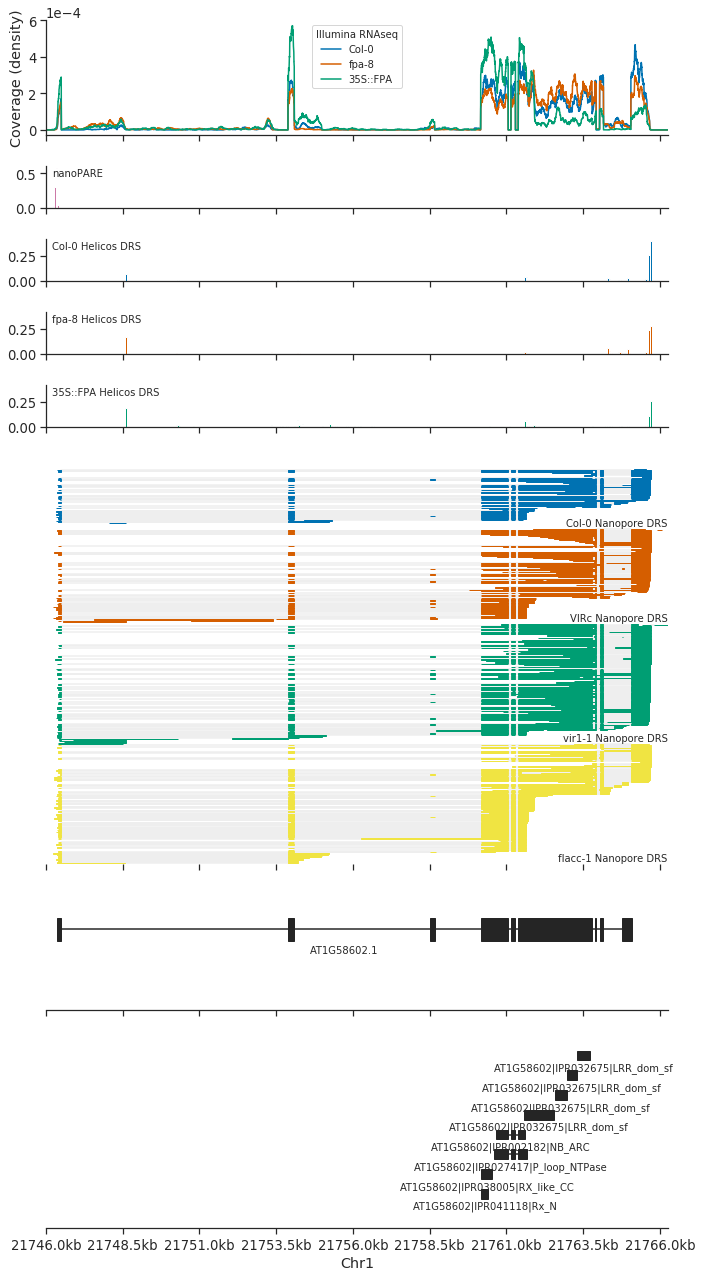

In [55]:
plot_vir1_nanopore_helicos_illumina(
    query=('1', 21746000, 21766251, '+'),
    annot_whitelist=['AT1G58602.1'],
    figsize=(10, 18),
    nanopore_rows=6,
    annot_rows=2,
    nanopore_sample_size=200,
    helicos_binsize=50,
    add_nanoPARE=True,
    add_interpro=True,
    add_chromatin_state=False,
    interpro_rows=3,
    illumina_y='Coverage (density)'
)
plt.savefig('figures/rpp7_vir1.svg')
plt.show()